# Re-running model

# Normal Installs/Imports

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
# check that the condacolab installation went smoothly


✨🍰✨ Everything looks OK!


In [ ]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# use conda to install mmseqs2
!conda install -c conda-forge -c bioconda mmseqs2

!pip install Bio
!pip install transformers
!pip install fair-esm
!pip install scikit-learn

import pandas as pd
from Bio import SeqIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import esm
import pickle
import json

from sklearn import tree, metrics
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, ParameterGrid, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# Mounting Drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I'll be starting with the classification task. The task is to determine whether a given sequence is anti-CRISPR or not.

# Loading in/cleaning dataset

In [ ]:
#loading dataset

path_to_590_folder ='/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A Data'

# Read file using pd.read_csv()
data = pd.read_csv(f'{path_to_590_folder}/anti_crispr.csv')

# print dataset size
print('size of dataset: ', len(data))

# view the first 5 rows of the dataset
data.head()

size of dataset:  4433


Unnamed: 0                                           Sequence  Anti-CRISPR?
0           0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...             0
1           1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...             0
2           2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...             0
3           3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...             0
4           4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...             0

Checking for invalid amino acids and removing any. Then sorting sequences by length

In [ ]:
#Cleaning my data
## check for invalid amino acids

# define set {} of valid AAs
valid_AAs = {'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'}

# define method to check a sequence for invalid characters
def contains_invalid_char(seq):
  unique_chars = set(seq) # set of all characters in the protein; unique_chars = {A, C} for protein="AAACCC"

  if unique_chars.issubset(valid_AAs):  # e.g. unique_chars = {A,C}, and {A,C} is a subset of valid_AAs
    return ''
  else: # e.g. unique_chars = {A,X}. {A,X} is not a subset of valid_AAs because X is not in valid_AAs
    return unique_chars.difference(valid_AAs) # e.g. {A,X} - valid_AAs = {X}

# apply our method contaisn_invalid_char to the sequence column
data['invalid_chars'] = data['Sequence'].apply(contains_invalid_char)
# display rows where there's an invalid character
data[data['invalid_chars'].str.len()>0].sort_values(by='Sequence')

Unnamed: 0                                           Sequence  \
3457        3457  CYFQNCPRGXXXAMSDLELRQCLPCGPGGKGRCFGPSICCGDELGC...   
3310        3310  IQSTSMDQGBLSEDSMNSFIRTLIQAGIWKNKVPKQTARTKDGTQT...   
2726        2726  LFNEKTVKYIPIHYVLSRYPSXGLNYYQHRLAALINNQFMPYPYYA...   
3918        3918  MAENQNYGTGRRKSSSARVFIKPGSGKITINQRELDVYFGRETARM...   
2872        2872  MAPSGLKAVVGEKILSGVIRSVKKDGEWKVLIMDHPSMRILSSCCK...   
1172        1172  MELGNQPGQGNRPEIELEWYQYLQNTVGEALSNYGWYILLGCIVIY...   
2911        2911  MERQEESLSARPALETEGLRFLHTTVGSLLATYGWYIVFSCILLYV...   
2604        2604  METDTLLLWVLLLWVPGSTGDIVLTQSPASLAVSLGQRATISCRAS...   
544          544  MKIDIHSHILPKEWPDLKKRFGYXGWVELQHHSEGEAKMLKDGKVF...   
4103        4103  MPALLKRLLFQVGPHPNERTFTLSSVSTDGHYISLRXFVKPSGDEL...   
2234        2234  MPPKPTYVSGGSVTQTGRSKWRLSYIPEFIWGILNQITFFFSTLIG...   
2091        2091  MSFCSFFGGEVFQNHFEPGVYVCAKCSYELFSSHSKYAHSSPWPAF...   
776          776  MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...   
2703        2703  MVHNDLDFIFYNNLKHSSGAIEHLGDNLTGDGDXDDEEIIIDLSLI...   
1822        1822  RLYYLRNGARISVSAASKLXSNMMYQYRGMGLSMGSMICGWDKKGP...   
1555        1555  VEWTDFERATIKDIFSKIEYDVVGPATLARCLVVYPWTQRYFGKFG...   

      Anti-CRISPR? invalid_chars  
3457             0           {X}  
3310             0           {B}  
2726             0           {X}  
3918             0           {X}  
2872             0           {X}  
1172             0           {U}  
2911             0           {U}  
2604             0        {Z, B}  
544              0           {X}  
4103             0           {X}  
2234             0           {U}  
2091             0           {U}  
776              0           {U}  
2703             0           {X}  
1822             0           {X}  
1555             0           {X}

In [ ]:
#we'll drop this data that doesn't have one of the 20 normal amino acids
# drop the sequences with invalid characters
data = data[data['invalid_chars'].str.len()==0].reset_index(drop=True).drop(columns=['invalid_chars'])
print('size of dataset without invalid characters: ', len(data))

size of dataset without invalid characters:  4417


removing duplicate sequences

In [ ]:
#now i'll look for duplicate sequences and get rid of them.
#i only want one fluorescence value per sequnence

duplicated_sequences = list(data[data.duplicated('Sequence')]['Sequence'])

# view the part of the dataframe with duplicated sequences
data[data['Sequence'].isin(duplicated_sequences)].sort_values(by='Sequence').reset_index(drop=True)

Unnamed: 0                                           Sequence  \
0          2025  MADLAKIVEDLSALTVLEAAELSKLLEEKWGVSAAAPVAVAAAGGA...   
1          3760  MADLAKIVEDLSALTVLEAAELSKLLEEKWGVSAAAPVAVAAAGGA...   
2           628  MAGDSISADGTGVHPVELSVYSVLSTDLDGLYQSINELRESQALLI...   
3          4284  MAGDSISADGTGVHPVELSVYSVLSTDLDGLYQSINELRESQALLI...   
4          3762  MAIIPDKQDSTVLERKQQKLKPPSMYKVVLLNDDFTPMEFVVMVVQ...   
..          ...                                                ...   
418        2976  MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...   
419        2679  MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...   
420         388  MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...   
421        1506  MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...   
422        1005  MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...   

     Anti-CRISPR?  
0               0  
1               0  
2               0  
3               0  
4               0  
..            ...  
418             1  
419             1  
420             1  
421             1  
422             1  

[423 rows x 3 columns]

In [ ]:
# Remove duplicate sequences, keeping only the first occurrence
data = data.drop_duplicates(subset='Sequence', keep='first').reset_index(drop=True)

data

Unnamed: 0                                           Sequence  \
0              0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...   
1              1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...   
2              2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...   
3              3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...   
4              4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...   
...          ...                                                ...   
4113        4428  MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAV...   
4114        4429  MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSL...   
4115        4430  MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVG...   
4116        4431  MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMG...   
4117        4432  MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAG...   

      Anti-CRISPR?  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
4113             0  
4114             0  
4115             0  
4116             0  
4117             0  

[4118 rows x 3 columns]

the dataset is now of size 4118. i'll now do a few more steps to process the data, such as filtering by sequence length

In [ ]:
# add an ID for clustering
data['id'] = [f'seq{i}' for i in range(len(data))]
data

Unnamed: 0                                           Sequence  \
0              0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...   
1              1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...   
2              2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...   
3              3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...   
4              4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...   
...          ...                                                ...   
4113        4428  MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAV...   
4114        4429  MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSL...   
4115        4430  MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVG...   
4116        4431  MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMG...   
4117        4432  MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAG...   

      Anti-CRISPR?       id  
0                0     seq0  
1                0     seq1  
2                0     seq2  
3                0     seq3  
4                0     seq4  
...            ...      ...  
4113             0  seq4113  
4114             0  seq4114  
4115             0  seq4115  
4116             0  seq4116  
4117             0  seq4117  

[4118 rows x 4 columns]

In [ ]:
# add a length column
data['length'] = data['Sequence'].str.len()

# keep only sequences <=400 AAs
data = data.loc[data['length']<=400].reset_index(drop=True)
print('size of dataset without sequences longer than 400 AA: ', len(data))
data

size of dataset without sequences longer than 400 AA:  4118


Unnamed: 0                                           Sequence  \
0              0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...   
1              1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...   
2              2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...   
3              3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...   
4              4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...   
...          ...                                                ...   
4113        4428  MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAV...   
4114        4429  MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSL...   
4115        4430  MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVG...   
4116        4431  MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMG...   
4117        4432  MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAG...   

      Anti-CRISPR?       id  length  
0                0     seq0     114  
1                0     seq1     133  
2                0     seq2     191  
3                0     seq3     118  
4                0     seq4     163  
...            ...      ...     ...  
4113             0  seq4113     167  
4114             0  seq4114     161  
4115             0  seq4115     148  
4116             0  seq4116     146  
4117             0  seq4117     137  

[4118 rows x 5 columns]

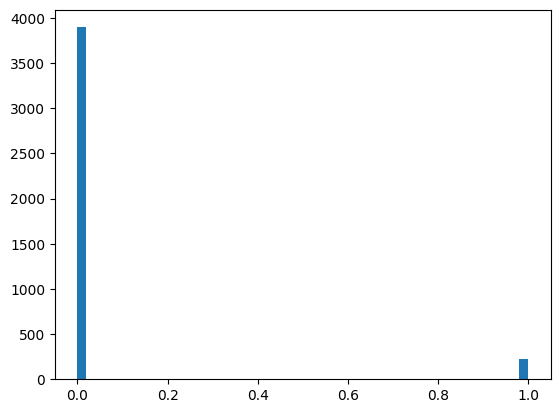

In [ ]:
# create a quick histogram of target values
plt.hist(data['Anti-CRISPR?'], bins=50) # the DPI parameter is helpful to adjust for sharper figures.
plt.show()

I see at this point that my distribution of targets is super uneven. The vast majority of the data represents sequences that are not anti-CRISPR. I'll keep this in mind, and move to the next step, clustering.

------------

# Clustering the 0 data

In [ ]:
# write the fasta
zerodata = data[data['Anti-CRISPR?']==0].reset_index(drop=True)
with open('zerodata.fasta', 'w') as f:
  for i in range(len(zerodata)):
    id = zerodata.loc[i,'id']
    seq = zerodata.loc[i,'Sequence']
    f.write(f'>{id}\n{seq}\n')

# check what you wrote - make sure it looks right
with open('zerodata.fasta', 'r') as f:
  lines = f.readlines()
  print(''.join(lines[0:6]))

>seq0
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAVVSLGLGMLLWLRLLQQLPLSVAYPMLSFNFVLVTLAAQLFYGEKATLRHWLGVAAIMFGILLMSWHL
>seq1
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGPMVIRQMDRGGIDLAILDGEATPTGGMGIAKQLKDELASCPPILVLTGRPDDTWLASWSRAEAAVPHPVDPIVLGRTVLSLLRAPAH
>seq2
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEKVISVIAEKLKEVDFNIIVGPAMGGVIVSYELARQTNKPGIFAERKEGVMCIRRGFEIKKGDKVIISEDVVTTGKSSLEVAKVIEEMGGEVVGIACIVDRRAEDIKTNYPIYSACKLEIETYEKDNCELCKKNIPFVKPGSREQK



In [ ]:
!mmseqs easy-cluster zerodata.fasta clusterRes_0s mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0

Create directory mmseqs_results
easy-cluster zerodata.fasta clusterRes_0s mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.5
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask res

In [ ]:
fasta_sequences = SeqIO.parse(open('clusterRes_0s_rep_seq.fasta'),'fasta')
id_list = []
seq_list = []

for fasta in fasta_sequences:
  id, sequence = fasta.id, str(fasta.seq)

  id_list.append(id)
  seq_list.append(sequence)

cluster_reps = pd.DataFrame(
    data = {
        'representative id': id_list,
        'sequence': seq_list
    }
)

print('Total clusters: {}'.format(len(cluster_reps)))
cluster_reps.head()

Total clusters: 1489


representative id                                           sequence
0           seq3407  MDDTLFQLKFTSKQLERLAKKAEKDSKSEQAKVKKALQQKNVECAR...
1           seq3410  MQEQATSSIAASSLPSSSERSSSSALHHELKEGMESDDEIRRVPEM...
2           seq3411  MELNTKNFGIIHYNEEDVIYFEEGIPGFEELHNFLIIGDEEEDMPF...
3           seq3413  MTLSILVAHDLQRVIGFENQLPWHLPNDLKHVKKLSTGHTLVMGRK...
4           seq3414  MGGGERFNIPGQHRNNLGKQIARQKLFDRNNQKMSMSHTKDRSRGC...

In [ ]:
clusters = pd.read_csv(f'clusterRes_0s_cluster.tsv',sep='\t',header=None)
print('Total cluster members: {}'.format(len(clusters)))
print('All sequences were clustered: {}'.format(len(clusters)==len(data)))
clusters = clusters.rename(columns={
    0: 'representative id',
    1: 'member id'
})
clusters.head()

Total cluster members: 3895
All sequences were clustered: False


representative id member id
0            seq221    seq221
1            seq221    seq137
2            seq221   seq1049
3            seq221    seq579
4            seq221   seq2267

In [ ]:
clusters = pd.merge(clusters,
                    zerodata.rename(columns={'id': 'member id',
                                            'Length':'length',
                                            'Sequence':'sequence'}),
                    on='member id',how='left')
clusters

representative id member id  Unnamed: 0  \
0               seq221    seq221         223   
1               seq221    seq137         138   
2               seq221   seq1049        1086   
3               seq221    seq579         596   
4               seq221   seq2267        2397   
...                ...       ...         ...   
3890            seq637   seq2420        2564   
3891            seq637    seq840         870   
3892            seq644    seq644         664   
3893            seq645    seq645         665   
3894            seq648    seq648         668   

                                               sequence  Anti-CRISPR?  length  
0     MTRPISFVTGNAKKLEEVRAILGPKFPRELLPVKLDLPELQGEIDD...             0     188  
1     MTLRKINFVTGNAKKLQEVKEILKGFEVTNVDVDLNEYQGEPEFIA...             0     184  
2     MLFITSNRHKYEEAAEFLGNYNIDIKWKNMKYEEIQGDTNKEISMD...             0     178  
3     MHKIVFVTGNKGKFAEIRDILKTFGIEVIQEKNGYPELQEDELEPI...             0     184  
4     MAPTEITFVTGNANKLKEVQMLLAAEDKKGSITLKNEPLDLDELQD...             0     192  
...                                                 ...           ...     ...  
3890  MRHRNGNRKLNRTSSHRAAMLRNMANSLLTHEAIVTTLPKAKELRR...             0     122  
3891  MRHRHGLRKLNRTSSHRLAMLRNMSNSLFQHELIKTTLPKAKELRK...             0     131  
3892  MEIAFLNSLVVTSPGFYKAEKITLDEVKQWLKHYDGRYKSFIGHKS...             0     108  
3893  MVGLSRLRGGGLLLVLALLPLALDGKPLEEAPTAPSRIIPFSRPVR...             0     139  
3894  MSRLMIVLVVLLSLAVAGLFLVKHKNASLRASLDRANNVASGQQTT...             0     141  

[3895 rows x 6 columns]

In [ ]:
# group by cluster representative, create a dataframe with average protein length and size of each cluster
sizedict = pd.DataFrame(clusters.groupby('representative id').count()['member id']).to_dict()['member id']
clustersgb = clusters.groupby('representative id').agg(
    avg_length=pd.NamedAgg(column="length", aggfunc="mean"),
).reset_index()
clustersgb['cluster_size'] = clustersgb['representative id'].apply(lambda x: sizedict[x])
clustersgb = clustersgb.sort_values(by='cluster_size',ascending=False).reset_index(drop=True)

#print('Total ppis = {}, should = len(merged)={}'.format(sum(clustersgb['ppis']),len(merged)))
clustersgb

representative id  avg_length  cluster_size
0              seq1928  119.666667            36
1               seq340  187.000000            35
2               seq887  139.411765            34
3              seq3002  156.031250            32
4              seq1948  118.406250            32
...                ...         ...           ...
1484           seq2461  114.000000             1
1485           seq2460  156.000000             1
1486           seq2459  122.000000             1
1487           seq2450  110.000000             1
1488           seq2474  195.000000             1

[1489 rows x 3 columns]

In [ ]:
# group by cluster representative, create a dataframe with average protein length and size of each cluster
sizedict = pd.DataFrame(clusters.groupby('representative id').count()['member id']).to_dict()['member id']
clustersgb = clusters.groupby('representative id').agg(
    avg_length=pd.NamedAgg(column="length", aggfunc="mean"),
).reset_index()
clustersgb['cluster_size'] = clustersgb['representative id'].apply(lambda x: sizedict[x])
clustersgb = clustersgb.sort_values(by='cluster_size',ascending=False).reset_index(drop=True)

#print('Total ppis = {}, should = len(merged)={}'.format(sum(clustersgb['ppis']),len(merged)))
clustersgb

representative id  avg_length  cluster_size
0              seq1928  119.666667            36
1               seq340  187.000000            35
2               seq887  139.411765            34
3              seq3002  156.031250            32
4              seq1948  118.406250            32
...                ...         ...           ...
1484           seq2461  114.000000             1
1485           seq2460  156.000000             1
1486           seq2459  122.000000             1
1487           seq2450  110.000000             1
1488           seq2474  195.000000             1

[1489 rows x 3 columns]

In [ ]:
# random train-val-test split
X = list(clustersgb['representative id'])
y = [0]*len(X)

# cluster with random state fixed for reproducible results
rs=45
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.20, random_state=rs) # 80-20 train-test else

train_clustersgb_0 = clustersgb[clustersgb['representative id'].isin(X_train_0)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)
test_clustersgb_0 = clustersgb[clustersgb['representative id'].isin(X_test_0)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)

In [ ]:
# now, evaluate
total_proteins = len(zerodata)
total_clusters = len(clustersgb)

train_clusters = len(X_train_0)
test_clusters = len(X_test_0)

train_proteins = sum(train_clustersgb_0['cluster_size'])
test_proteins = sum(test_clustersgb_0['cluster_size'])

print('clusters in train: {} ({:.2f}%)'.format(train_clusters, 100*train_clusters/total_clusters))
print('clusters in test: {} ({:.2f}%)'.format(test_clusters, 100*test_clusters/total_clusters))
print('\ntrain clusters + test clusters = {} = total # clusters = {}'.format(
    train_clusters + test_clusters,
    total_clusters
    ))

print('\nproteins in train: {} ({:.2f}%)'.format(train_proteins, 100*train_proteins/total_proteins))
print('proteins in test: {} ({:.2f}%)'.format(test_proteins, 100*test_proteins/total_proteins))
print('\ntrain proteins + test proteins = {} = total # proteins = {}'.format(
    train_proteins + test_proteins,
    total_proteins
    ))

clusters in train: 1191 (79.99%)
clusters in test: 298 (20.01%)

train clusters + test clusters = 1489 = total # clusters = 1489

proteins in train: 3056 (78.46%)
proteins in test: 839 (21.54%)

train proteins + test proteins = 3895 = total # proteins = 3895


In [ ]:
# save a copy of the clusters dataset to combine with class 1
clusters_0 = clusters.copy(deep=True)

# now we cluster the 1 data

In [ ]:
# write the fasta
onedata =data[data['Anti-CRISPR?']==1].reset_index(drop=True)
with open('one.fasta', 'w') as f:
  for i in range(len(onedata)):
    id = onedata.loc[i,'id']
    seq = onedata.loc[i,'Sequence']
    f.write(f'>{id}\n{seq}\n')

# check what you wrote - make sure it looks right
with open('one.fasta', 'r') as f:
  lines = f.readlines()
  print(''.join(lines[0:6]))

>seq16
MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWSKAKEEVKEVEKEIKHISKSEELKAWNWAERKLGLRFNISDDEKFTSVKDETKQHFGLSVWACAMKAVKLHNDLFPQTAA
>seq22
MTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK
>seq26
MDEIEDLSDLPMPRFIWGFAVIAGKGGEVMHDEFEYLTHTRSPRFTCRVVELEDMPAESEEDAIDGRIVHDDDPSRMFYITDAGMALVNFQLFDKMPDKQKLKRICDEAIANWMLRREFLDEEEDD



In [ ]:
!mmseqs easy-cluster one.fasta clusterRes_ones mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0

easy-cluster one.fasta clusterRes_ones mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.5
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask

In [ ]:
fasta_sequences = SeqIO.parse(open('clusterRes_ones_rep_seq.fasta'),'fasta')
id_list = []
seq_list = []

for fasta in fasta_sequences:
  id, sequence = fasta.id, str(fasta.seq)

  id_list.append(id)
  seq_list.append(sequence)

cluster_reps = pd.DataFrame(
    data = {
        'representative id': id_list,
        'sequence': seq_list
    }
)

print('Total clusters: {}'.format(len(cluster_reps)))
cluster_reps.head()

Total clusters: 39


representative id                                           sequence
0             seq45  MIDFNSIDHAIALIQKDPEQANAIAGEYAYQMAREAYEIASESGFG...
1             seq74  MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKPLNKYTVSI...
2            seq169  MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWS...
3            seq259  MLYSEKVMDHFMHPRNVGEMENPSGVGEVGNAKCGDIMRMYLKIDE...
4            seq307  MTIYLSNAIENATSIEQVVELINEGTCEGMEGIEFTADILAGQYAW...

In [ ]:
clusters = pd.read_csv(f'clusterRes_ones_cluster.tsv',sep='\t',header=None)
print('Total cluster members: {}'.format(len(clusters)))
print('All sequences were clustered: {}'.format(len(clusters)==len(data)))
clusters = clusters.rename(columns={
    0: 'representative id',
    1: 'member id'
})
clusters.head()

Total cluster members: 223
All sequences were clustered: False


representative id member id
0             seq45     seq45
1             seq74     seq74
2             seq74    seq139
3             seq74    seq223
4             seq74    seq227

In [ ]:
clusters = pd.merge(clusters,
                    onedata.rename(columns={'id': 'member id',
                                            'Length':'length',
                                            'Sequence':'sequence'}),
                    on='member id',how='left')
clusters

representative id member id  Unnamed: 0  \
0               seq45     seq45          45   
1               seq74     seq74          74   
2               seq74    seq139         140   
3               seq74    seq223         225   
4               seq74    seq227         229   
..                ...       ...         ...   
218           seq3790   seq1793        1880   
219           seq3790   seq1860        1949   
220           seq3790   seq1935        2031   
221           seq3805   seq3805        4090   
222           seq3924   seq3924        4219   

                                              sequence  Anti-CRISPR?  length  
0    MIDFNSIDHAIALIQKDPEQANAIAGEYAYQMAREAYEIASESGFG...             1      86  
1    MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKPLNKYTVSI...             1     149  
2    MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKSLNKYTVSI...             1     149  
3    MSIKLLDEFLKKHSKTRYQLSKLTGISQNTLNDYNKKELNKYSVSF...             1     149  
4    MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKSLNKYTVSI...             1     149  
..                                                 ...           ...     ...  
218  MDEIDDLSDLPMPRFIWGFAIFTPKGGEVMHDEFEYLTHTRAPRFT...             1     128  
219  MDEIEDLSDLPMPRFIWGFAVIAGKSGEVMHDEFEYLTHTRSPRFT...             1     126  
220  MDEIDDLSDLPMPRFIWGFAIATGKGGEVMHDEFEYLTHTRSPRFT...             1     127  
221  MKFIKYLSTAHLNYMNIAVYENGSKIKARVENVVNGKSVGARDFDS...             1      78  
222  MNTTYVLRQSDNLVFNIEGETFTFMARRLADVKRRAIRKQFHEDSN...             1      70  

[223 rows x 6 columns]

In [ ]:
# group by cluster representative, create a dataframe with average protein length and size of each cluster
sizedict = pd.DataFrame(clusters.groupby('representative id').count()['member id']).to_dict()['member id']
clustersgb = clusters.groupby('representative id').agg(
    avg_length=pd.NamedAgg(column="length", aggfunc="mean"),
).reset_index()
clustersgb['cluster_size'] = clustersgb['representative id'].apply(lambda x: sizedict[x])
clustersgb = clustersgb.sort_values(by='cluster_size',ascending=False).reset_index(drop=True)

#print('Total ppis = {}, should = len(merged)={}'.format(sum(clustersgb['ppis']),len(merged)))
clustersgb

representative id  avg_length  cluster_size
0            seq3790  128.477273            44
1              seq74  145.900000            30
2            seq2614  120.105263            19
3             seq169  125.000000            14
4            seq3211  111.307692            13
5             seq864   71.000000            13
6            seq2345  123.750000            12
7            seq2828   78.200000            10
8            seq1439  102.875000             8
9            seq3400  237.250000             8
10           seq3397  197.625000             8
11            seq541   86.714286             7
12           seq3109   90.250000             4
13           seq1444  100.000000             3
14           seq2302   90.500000             2
15            seq307   97.000000             2
16           seq2948   97.000000             2
17           seq2404  139.500000             2
18           seq3733   93.000000             2
19           seq2204  211.000000             1
20           seq2019  140.000000             1
21           seq1701   79.000000             1
22           seq2398  117.000000             1
23           seq3455   85.000000             1
24           seq3212   89.000000             1
25           seq3144   64.000000             1
26           seq3032  100.000000             1
27            seq259  149.000000             1
28           seq3566   97.000000             1
29           seq3460   68.000000             1
30            seq348  270.000000             1
31           seq3924   70.000000             1
32           seq3805   78.000000             1
33            seq351   95.000000             1
34            seq438   94.000000             1
35            seq662   52.000000             1
36             seq45   86.000000             1
37            seq702   84.000000             1
38            seq981  100.000000             1

In [ ]:
# get a sense of cluster quality
print('Total clusters: {}'.format(len(clustersgb)))
print('\tTotal sequences: {}'.format(sum(clustersgb['cluster_size'])))
print('\nNumber of clusters of size 1: {}'.format(len(clustersgb[clustersgb['cluster_size']==1])))
print('\tTotal sequences in size-1 clusters: {}'.format(sum(clustersgb[clustersgb['cluster_size']==1]['cluster_size'])))
print('Number of clusters of size > 1: {}'.format(len(clustersgb[clustersgb['cluster_size']>1])))
print('\tTotal sequences in size >1 clusters: {}'.format(sum(clustersgb[clustersgb['cluster_size']>1]['cluster_size'])))

Total clusters: 39
	Total sequences: 223

Number of clusters of size 1: 20
	Total sequences in size-1 clusters: 20
Number of clusters of size > 1: 19
	Total sequences in size >1 clusters: 203


In [ ]:
# random train-val-test split
X = list(clustersgb['representative id'])
y = [1]*len(X)

# cluster with random state fixed for reproducible results
rs=46
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.20, random_state=rs) # 80-20 train-test else

train_clustersgb_1 = clustersgb[clustersgb['representative id'].isin(X_train_1)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)
test_clustersgb_1 = clustersgb[clustersgb['representative id'].isin(X_test_1)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)

In [ ]:
# now, evaluate
total_proteins = len(onedata)
total_clusters = len(clustersgb)

train_clusters = len(X_train_1)
test_clusters = len(X_test_1)

train_proteins = sum(train_clustersgb_1['cluster_size'])
test_proteins = sum(test_clustersgb_1['cluster_size'])

print('clusters in train: {} ({:.2f}%)'.format(train_clusters, 100*train_clusters/total_clusters))
print('clusters in test: {} ({:.2f}%)'.format(test_clusters, 100*test_clusters/total_clusters))
print('\ntrain clusters + test clusters = {} = total # clusters = {}'.format(
    train_clusters + test_clusters,
    total_clusters
    ))

print('\nproteins in train: {} ({:.2f}%)'.format(train_proteins, 100*train_proteins/total_proteins))
print('proteins in test: {} ({:.2f}%)'.format(test_proteins, 100*test_proteins/total_proteins))
print('\ntrain proteins + test proteins = {} = total # proteins = {}'.format(
    train_proteins + test_proteins,
    total_proteins
    ))

clusters in train: 31 (79.49%)
clusters in test: 8 (20.51%)

train clusters + test clusters = 39 = total # clusters = 39

proteins in train: 168 (75.34%)
proteins in test: 55 (24.66%)

train proteins + test proteins = 223 = total # proteins = 223


In [ ]:
clusters_1 = clusters.copy(deep=True)

In [ ]:
clusters = pd.concat([clusters_0,clusters_1]).reset_index(drop=True)
clusters

representative id member id  Unnamed: 0  \
0               seq221    seq221         223   
1               seq221    seq137         138   
2               seq221   seq1049        1086   
3               seq221    seq579         596   
4               seq221   seq2267        2397   
...                ...       ...         ...   
4113           seq3790   seq1793        1880   
4114           seq3790   seq1860        1949   
4115           seq3790   seq1935        2031   
4116           seq3805   seq3805        4090   
4117           seq3924   seq3924        4219   

                                               sequence  Anti-CRISPR?  length  
0     MTRPISFVTGNAKKLEEVRAILGPKFPRELLPVKLDLPELQGEIDD...             0     188  
1     MTLRKINFVTGNAKKLQEVKEILKGFEVTNVDVDLNEYQGEPEFIA...             0     184  
2     MLFITSNRHKYEEAAEFLGNYNIDIKWKNMKYEEIQGDTNKEISMD...             0     178  
3     MHKIVFVTGNKGKFAEIRDILKTFGIEVIQEKNGYPELQEDELEPI...             0     184  
4     MAPTEITFVTGNANKLKEVQMLLAAEDKKGSITLKNEPLDLDELQD...             0     192  
...                                                 ...           ...     ...  
4113  MDEIDDLSDLPMPRFIWGFAIFTPKGGEVMHDEFEYLTHTRAPRFT...             1     128  
4114  MDEIEDLSDLPMPRFIWGFAVIAGKSGEVMHDEFEYLTHTRSPRFT...             1     126  
4115  MDEIDDLSDLPMPRFIWGFAIATGKGGEVMHDEFEYLTHTRSPRFT...             1     127  
4116  MKFIKYLSTAHLNYMNIAVYENGSKIKARVENVVNGKSVGARDFDS...             1      78  
4117  MNTTYVLRQSDNLVFNIEGETFTFMARRLADVKRRAIRKQFHEDSN...             1      70  

[4118 rows x 6 columns]

In [ ]:
sizedict = pd.DataFrame(clusters.groupby('representative id').count()['member id']).to_dict()['member id']
clustersgb = clusters.groupby('representative id').agg(
    avg_length=pd.NamedAgg(column="length", aggfunc="mean"),
).reset_index()
clustersgb['cluster_size'] = clustersgb['representative id'].apply(lambda x: sizedict[x])
clustersgb = clustersgb.sort_values(by='cluster_size',ascending=False).reset_index(drop=True)

# Making final train/test sets

In [ ]:
# create the final X_train: combine X_train_TF and X_train_TM
X_train = X_train_0.copy()
X_train.extend(X_train_1)

# create the final X_test: combine X_test_TF and X_test_TM
X_test = X_test_0.copy()
X_test.extend(X_test_1)

# create the final y_train: combine y_train_TF and y_train_TM
y_train = y_train_0
y_train.extend(y_train_1)

# create the final y_test: combine y_test_TF and y_test_TM
y_test = y_test_0
y_test.extend(y_test_1)

# create grouped cluster dataframes for train and for test
train_clustersgb = clustersgb[clustersgb['representative id'].isin(X_train)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)
test_clustersgb = clustersgb[clustersgb['representative id'].isin(X_test)].sort_values(by=['cluster_size'],ascending=False).reset_index(drop=True)


In [ ]:
# now, make sure clustering results make sense
total_proteins = len(data)
total_clusters = len(clustersgb)

train_clusters = len(X_train)
test_clusters = len(X_test)

train_proteins = sum(train_clustersgb['cluster_size'])
test_proteins = sum(test_clustersgb['cluster_size'])

print('clusters in train: {} ({:.2f}%)'.format(train_clusters, 100*train_clusters/total_clusters))
print('clusters in test: {} ({:.2f}%)'.format(test_clusters, 100*test_clusters/total_clusters))
print('\ntrain clusters + test clusters = {} = total # clusters = {}'.format(
    train_clusters + test_clusters,
    total_clusters
    ))

print('\nproteins in train: {} ({:.2f}%)'.format(train_proteins, 100*train_proteins/total_proteins))
print('proteins in test: {} ({:.2f}%)'.format(test_proteins, 100*test_proteins/total_proteins))
print('\ntrain proteins + test proteins = {} = total # proteins = {}'.format(
    train_proteins + test_proteins,
    total_proteins
    ))

clusters in train: 1222 (79.97%)
clusters in test: 306 (20.03%)

train clusters + test clusters = 1528 = total # clusters = 1528

proteins in train: 3224 (78.29%)
proteins in test: 894 (21.71%)

train proteins + test proteins = 4118 = total # proteins = 4118


In [ ]:
clusters.head()

representative id member id  Unnamed: 0  \
0            seq221    seq221         223   
1            seq221    seq137         138   
2            seq221   seq1049        1086   
3            seq221    seq579         596   
4            seq221   seq2267        2397   

                                            sequence  Anti-CRISPR?  length  
0  MTRPISFVTGNAKKLEEVRAILGPKFPRELLPVKLDLPELQGEIDD...             0     188  
1  MTLRKINFVTGNAKKLQEVKEILKGFEVTNVDVDLNEYQGEPEFIA...             0     184  
2  MLFITSNRHKYEEAAEFLGNYNIDIKWKNMKYEEIQGDTNKEISMD...             0     178  
3  MHKIVFVTGNKGKFAEIRDILKTFGIEVIQEKNGYPELQEDELEPI...             0     184  
4  MAPTEITFVTGNANKLKEVQMLLAAEDKKGSITLKNEPLDLDELQD...             0     192

In [ ]:
train_sequences = list(clusters[clusters['representative id'].isin(X_train)]['sequence'])
test_sequences = list(clusters[clusters['representative id'].isin(X_test)]['sequence'])
print('train sequences: ', len(train_sequences))
print('test sequences: ', len(test_sequences))
print('total: ', len(train_sequences)+len(test_sequences))

train sequences:  3224
test sequences:  894
total:  4118


# ESM EMBEDDINGS

In [ ]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Create a DataFrame with the natural sequence data - we'll just use ONE sequence for now
sequence_data = pd.DataFrame(data['Sequence'])

# Initialize an empty list to store the averaged ESM embeddings
avg_embeddings = []

# Iterate through the DataFrame rows
for index, row in sequence_data.iterrows():
    sequence = row["Sequence"]

    # Prepare data for the ESM model
    batch_labels, batch_strs, batch_tokens = batch_converter([("", sequence)])
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (can be done on CPU!)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging
    avg_embedding = token_representations[0, 1 : batch_lens[0] - 1].mean(0)
    avg_embeddings.append(avg_embedding.numpy())

# Create a new DataFrame with the averaged embeddings
gen_embeddings = pd.DataFrame(avg_embeddings)
# Display the DataFrame
gen_embeddings

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


0         1         2         3         4         5         6    \
0    -0.273219  0.152761  0.412005  0.132104 -0.118797  0.165697  0.000580   
1    -0.103700 -0.070276 -0.021276 -0.225767  0.208563 -0.127431  0.028852   
2    -0.133317 -0.141296  0.225693  0.397102  0.260599 -0.280143  0.091071   
3    -0.172801 -0.290801  0.050661  0.146022  0.138824 -0.127177 -0.080269   
4    -0.224608  0.016961  0.209824  0.038388  0.150348  0.044310  0.110857   
...        ...       ...       ...       ...       ...       ...       ...   
4113  0.115074  0.042786  0.234316  0.093834  0.096560 -0.103509 -0.096767   
4114 -0.268953 -0.192262 -0.009782  0.304044  0.160833 -0.311748  0.262415   
4115  0.050988  0.064441  0.125261  0.237490  0.065024 -0.028460  0.052786   
4116 -0.040488  0.021213  0.083794 -0.002635  0.001545  0.190345 -0.021179   
4117 -0.147075 -0.134281  0.026216  0.018742  0.129021  0.009299  0.089515   

           7         8         9    ...       310       311       312  \
0    -0.158661 -0.079803  0.069416  ... -0.147052 -0.042018 -0.042957   
1    -0.036325 -0.289579 -0.089755  ... -0.069494 -0.034800 -0.019590   
2     0.008500 -0.240871 -0.052251  ...  0.131704 -0.026955  0.005204   
3    -0.048393 -0.036524 -0.071807  ...  0.004413  0.138791  0.044958   
4    -0.048460 -0.007785  0.165936  ...  0.216677  0.076921  0.065815   
...        ...       ...       ...  ...       ...       ...       ...   
4113 -0.263423  0.139981 -0.086259  ... -0.098302 -0.059417 -0.001183   
4114 -0.054228 -0.290236  0.051835  ...  0.019158 -0.038485 -0.011400   
4115 -0.070612  0.008894  0.035351  ...  0.027904  0.219063 -0.020947   
4116 -0.128547  0.030817 -0.103715  ... -0.090895  0.151980 -0.143790   
4117 -0.075896 -0.128506 -0.074460  ... -0.035913  0.154525  0.106925   

           313       314       315       316       317       318       319  
0     0.075511 -0.008200 -0.147973 -0.241718  0.126322 -0.130771  0.152834  
1     0.287711 -0.064927  0.013499 -0.053466  0.373028 -0.023114 -0.107388  
2     0.203375  0.020796 -0.052996 -0.118082  0.027513  0.077506  0.107486  
3     0.046562  0.010033 -0.117978 -0.125550  0.239248  0.052529 -0.119746  
4     0.232649  0.009215 -0.202214 -0.034331  0.246689  0.064565 -0.001609  
...        ...       ...       ...       ...       ...       ...       ...  
4113 -0.022439 -0.019531 -0.290398 -0.198088  0.217459 -0.061819 -0.256347  
4114  0.014378  0.184706 -0.050296  0.022688 -0.017064  0.041806 -0.007391  
4115  0.019536  0.107964 -0.218917  0.027999  0.122613 -0.181956  0.181281  
4116  0.054794  0.075414 -0.291795 -0.113412  0.155251 -0.029611 -0.009316  
4117  0.043010 -0.033017 -0.174482 -0.221142  0.106001  0.069155 -0.007306  

[4118 rows x 320 columns]

In [ ]:
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(gen_embeddings, f)
print(data['Sequence'])

0       MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...
1       MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...
2       MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...
3       MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...
4       MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...
                              ...                        
4113    MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAV...
4114    MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSL...
4115    MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVG...
4116    MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMG...
4117    MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAG...
Name: Sequence, Length: 4118, dtype: object


In [ ]:
# Load the pickle file
with open('embeddings.pkl', 'rb') as f:
    esm_embeddings = pickle.load(f)

esm_embeddings


0         1         2         3         4         5         6    \
0    -0.273219  0.152761  0.412005  0.132104 -0.118797  0.165697  0.000580   
1    -0.103700 -0.070276 -0.021276 -0.225767  0.208563 -0.127431  0.028852   
2    -0.133317 -0.141296  0.225693  0.397102  0.260599 -0.280143  0.091071   
3    -0.172801 -0.290801  0.050661  0.146022  0.138824 -0.127177 -0.080269   
4    -0.224608  0.016961  0.209824  0.038388  0.150348  0.044310  0.110857   
...        ...       ...       ...       ...       ...       ...       ...   
4113  0.115074  0.042786  0.234316  0.093834  0.096560 -0.103509 -0.096767   
4114 -0.268953 -0.192262 -0.009782  0.304044  0.160833 -0.311748  0.262415   
4115  0.050988  0.064441  0.125261  0.237490  0.065024 -0.028460  0.052786   
4116 -0.040488  0.021213  0.083794 -0.002635  0.001545  0.190345 -0.021179   
4117 -0.147075 -0.134281  0.026216  0.018742  0.129021  0.009299  0.089515   

           7         8         9    ...       310       311       312  \
0    -0.158661 -0.079803  0.069416  ... -0.147052 -0.042018 -0.042957   
1    -0.036325 -0.289579 -0.089755  ... -0.069494 -0.034800 -0.019590   
2     0.008500 -0.240871 -0.052251  ...  0.131704 -0.026955  0.005204   
3    -0.048393 -0.036524 -0.071807  ...  0.004413  0.138791  0.044958   
4    -0.048460 -0.007785  0.165936  ...  0.216677  0.076921  0.065815   
...        ...       ...       ...  ...       ...       ...       ...   
4113 -0.263423  0.139981 -0.086259  ... -0.098302 -0.059417 -0.001183   
4114 -0.054228 -0.290236  0.051835  ...  0.019158 -0.038485 -0.011400   
4115 -0.070612  0.008894  0.035351  ...  0.027904  0.219063 -0.020947   
4116 -0.128547  0.030817 -0.103715  ... -0.090895  0.151980 -0.143790   
4117 -0.075896 -0.128506 -0.074460  ... -0.035913  0.154525  0.106925   

           313       314       315       316       317       318       319  
0     0.075511 -0.008200 -0.147973 -0.241718  0.126322 -0.130771  0.152834  
1     0.287711 -0.064927  0.013499 -0.053466  0.373028 -0.023114 -0.107388  
2     0.203375  0.020796 -0.052996 -0.118082  0.027513  0.077506  0.107486  
3     0.046562  0.010033 -0.117978 -0.125550  0.239248  0.052529 -0.119746  
4     0.232649  0.009215 -0.202214 -0.034331  0.246689  0.064565 -0.001609  
...        ...       ...       ...       ...       ...       ...       ...  
4113 -0.022439 -0.019531 -0.290398 -0.198088  0.217459 -0.061819 -0.256347  
4114  0.014378  0.184706 -0.050296  0.022688 -0.017064  0.041806 -0.007391  
4115  0.019536  0.107964 -0.218917  0.027999  0.122613 -0.181956  0.181281  
4116  0.054794  0.075414 -0.291795 -0.113412  0.155251 -0.029611 -0.009316  
4117  0.043010 -0.033017 -0.174482 -0.221142  0.106001  0.069155 -0.007306  

[4118 rows x 320 columns]

In [ ]:
esm_embeddings.insert(0, 'Sequence', data['Sequence'])
esm_embeddings.set_index('Sequence', inplace=True)

esm_embeddings

0         1    \
Sequence                                                                 
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV... -0.273219  0.152761   
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGP... -0.103700 -0.070276   
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEK... -0.133317 -0.141296   
MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKISE... -0.172801 -0.290801   
MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASKT... -0.224608  0.016961   
...                                                      ...       ...   
MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAVN...  0.115074  0.042786   
MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSLE... -0.268953 -0.192262   
MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVGL...  0.050988  0.064441   
MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMGR... -0.040488  0.021213   
MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAGG... -0.147075 -0.134281   

                                                         2         3    \
Sequence                                                                 
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV...  0.412005  0.132104   
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGP... -0.021276 -0.225767   
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEK...  0.225693  0.397102   
MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKISE...  0.050661  0.146022   
MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASKT...  0.209824  0.038388   
...                                                      ...       ...   
MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAVN...  0.234316  0.093834   
MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSLE... -0.009782  0.304044   
MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVGL...  0.125261  0.237490   
MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMGR...  0.083794 -0.002635   
MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAGG...  0.026216  0.018742   

                                                         4         5    \
Sequence                                                                 
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV... -0.118797  0.165697   
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGP...  0.208563 -0.127431   
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEK...  0.260599 -0.280143   
MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKISE...  0.138824 -0.127177   
MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASKT...  0.150348  0.044310   
...                                                      ...       ...   
MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAVN...  0.096560 -0.103509   
MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSLE...  0.160833 -0.311748   
MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVGL...  0.065024 -0.028460   
MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMGR...  0.001545  0.190345   
MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAGG...  0.129021  0.009299   

                                                         6         7    \
Sequence                                                                 
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV...  0.000580 -0.158661   
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGP...  0.028852 -0.036325   
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEK...  0.091071  0.008500   
MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKISE... -0.080269 -0.048393   
MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASKT...  0.110857 -0.048460   
...                                                      ...       ...   
MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAVN... -0.096767 -0.263423   
MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSLE...  0.262415 -0.054228   
MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVGL...  0.052786 -0.070612   
MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMGR... -0.021179 -0.128547   
MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAGG...  0.089515 -0.075896   

                                                         8         9    ...  \
Sequence                                                                ...   
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV

changing the index column to be the sequence itself. also adding a data label column

In [ ]:
data['Sequence'] = data['Sequence'].astype(str)

# Set the index of 'data' to be the 'Sequence' column
data.set_index('Sequence', inplace=True)

# Now, we can use the index of 'esm_embeddings' to match and add the 'Anti-CRISPR?' labels from 'data'
esm_embeddings['Label'] = data.loc[esm_embeddings.index, 'Anti-CRISPR?']


In [ ]:
esm_embeddings.iloc[0:5,318::]

318       319  Label
Sequence                                                                     
MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIAV... -0.130771  0.152834      0
MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATGP... -0.023114 -0.107388      0
MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAEK...  0.077506  0.107486      0
MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKISE...  0.052529 -0.119746      0
MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASKT...  0.064565 -0.001609      0

assigning my train and test sets for the esm embeddings

In [ ]:
# Features (X) - your protein features
# Labels (y) - your protein labels (0 or 1 for two classes)

# isolate train esm embeddings and test esm embeddings
train_esm_embeddings = esm_embeddings.loc[train_sequences]
test_esm_embeddings = esm_embeddings.loc[test_sequences]

# X_train = train esm embeddings, no 'label' column
X_train = np.array(train_esm_embeddings.drop(columns=['Label']).reset_index(drop=True))
X_test = np.array(test_esm_embeddings.drop(columns=['Label']).reset_index(drop=True))


# Then proceed with the mapping
train_labels = esm_embeddings.loc[train_sequences]['Label']
test_labels = esm_embeddings.loc[test_sequences]['Label']

# Convert to numpy array
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
test_labels

Sequence
MAEIGIFVGTMYGNSLLVAEEAEAILTAQGHKATVFEDPELSDWLPYQDKYVLVVTSTTGQGDLPDSIVPLFQGIKDSLGFQPNLRYGVIALGDSSYVNFCNGGKQFDALLQEQSAQRVGEMLLIDASENPEPETESNPWVEQWGTLLS                                                                                             0
MAQFEWVHAAWLALAIVLEIVANVFLKFSDGFRRKIFGLLSLAAVLAAFSALSQAVKGIDLSVAYALWGGFGIAATLAAGWILFGQRLNRKGWIGLVLLLAGMIMVKLA                                                                                                                                     0
MFYWILLALAIATEITGTLSMKWASVGNGNAGFILMLVMITLSYIFLSFAVKKIALGVAYALWEGIGILFITIFSVLLFDEALSTMKIAGLLTLVAGIVLIKSGTRKPGKPVKEATRATI                                                                                                                          0
MYIYWILLGLAIATEITGTLSMKWASVSEGNGGFILMLVMISLSYIFLSFAVKKIALGVAYALWEGIGILFITLFSVLLFDESLSLMKIAGLTTLVAGIVLIKSGTRKARKPELEVNHGAV                                                                                                                         0
MRGLLYLALAIVSEV

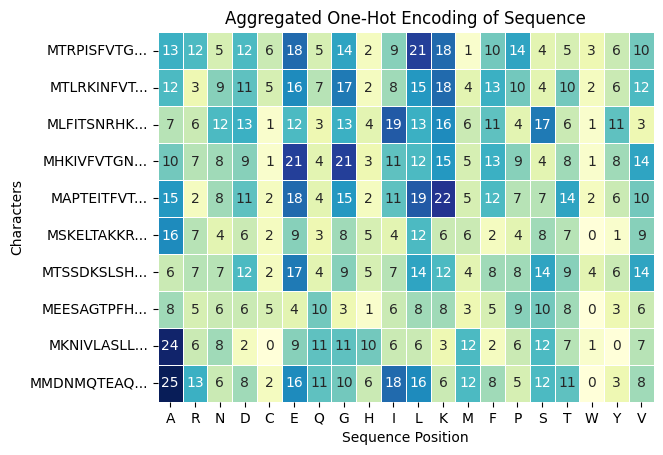

In [ ]:
# do one-hot aggregation for the train and test sets
def one_hot_encode_and_aggregate_proteins(protein_sequences):
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ARNDCEQGHILKMFPSTWYV')], dtype=int)

    # Initialize a list to hold the one-hot encoded arrays
    aggregated_sequences = []

    # Iterate over each protein sequence
    for seq in protein_sequences:
        # Convert the protein sequence into a 2D array
        amino_acids = np.array(list(seq)).reshape(-1, 1)

        # Fit and transform the amino acids
        encoded_seq = encoder.fit_transform(amino_acids).toarray()

        # Aggregate by summing across the amino acids
        aggregated_seq = np.sum(encoded_seq, axis=0)
        aggregated_sequences.append(aggregated_seq)

    return aggregated_sequences

# Example usage
train_onehot_agg = one_hot_encode_and_aggregate_proteins(train_sequences)
test_onehot_agg = one_hot_encode_and_aggregate_proteins(test_sequences)

def plot_onehot_agg(protein_sequences, encoded_sequences, unique_chars=list('ARNDCEQGHILKMFPSTWYV')):
  # Convert to DataFrame for easier plotting
  df_one_hot = pd.DataFrame(encoded_sequences, columns=unique_chars, index=[x[0:10]+'...' for x in protein_sequences])

  # Creating the heatmap
  #plt.figure(figsize=(len(protein_sequence)/2, len(unique_chars)))
  plt.figure()
  sns.heatmap(df_one_hot, annot=True, cmap="YlGnBu", cbar=False, linewidths=.5)

  plt.title("Aggregated One-Hot Encoding of Sequence")
  plt.ylabel("Characters")
  plt.yticks(rotation=0)
  plt.xlabel("Sequence Position")
  plt.show()

plot_onehot_agg(train_sequences[0:10], train_onehot_agg[0:10])

In [ ]:
# Check if there are any NaN values in y_train
nan_indices = np.where(np.isnan(y_train))[0]
print(f"Indices with NaN in y_train: {nan_indices}")


Indices with NaN in y_train: []


In [ ]:
import numpy as np

# Define VHSE values for each amino acid
vhse_values = {
    'A': [0.15, -1.11, -1.35, -0.92, 0.02, -0.91, 0.36, -0.48],
    'R': [-1.47, 1.45, 1.24, 1.27, 1.55, 1.47, 1.30, 0.83],
    'N': [-0.99, 0.00, 0.37, 0.69, -0.55, 0.85, 0.73, -0.80],
    'D': [-1.15, 0.67, 0.41, 0.01, -2.68, 1.31, 0.03, 0.56],
    'C': [0.18, -1.67, 0.46, -0.21, 0.00, 1.20, -1.61, -0.19],
    'Q': [-0.96, 0.12, 0.18, 0.16, 0.09, -0.42, -0.20, -0.41],
    'E': [-1.18, 0.40, 0.10, 0.36, -2.16, -0.17, 0.91, 0.02],
    'G': [-0.20, 1.53, -2.63, 2.28, -0.53, 1.18, 2.01, -1.34],
    'H': [-0.43, -0.25, 0.37, 0.19, 0.51, 1.28, 0.93, 0.65],
    'I': [1.27, -0.14, 0.30, -1.80, 0.30, -1.61, -0.16, -0.13],
    'L': [1.36, 0.07, 0.26, -0.80, 0.22, -1.37, 0.08, -0.62],
    'K': [-1.17, 0.70, 0.70, 0.80, 1.64, 0.67, 1.63, 0.13],
    'M': [1.01, -0.53, 0.43, 0.00, 0.23, 0.10, 0.86, -0.68],
    'F': [1.52, 0.61, 0.96, -0.16, 0.25, 0.28, 1.33, -0.20],
    'P': [0.22, -0.17, 0.50, 0.05, -0.01, -1.34, 0.19, 3.56],
    'S': [-0.67, 0.86, 1.07, -0.41, -0.32, 0.27, -0.64, 0.11],
    'T': [-0.34, 0.51, 0.55, -1.06, -0.06, 0.01, 0.79, 0.39],
    'W': [1.50, 2.06, 1.79, 0.75, 0.75, -0.13, 1.01, -0.85],
    'Y': [0.61, 1.60, 1.17, 0.73, 0.53, -0.96, 0.96, -0.52],
    'V': [0.76, -0.92, -0.17, -1.91, 0.22, -1.40, -0.24, -0.03],
}

def encode_proteins_vhse(protein_sequences, vhse_values):
    encoded_sequences = []
    for seq in protein_sequences:
        vhse_vectors = [vhse_values.get(aa, [0]*8) for aa in seq]
        encoded_seq_mean = np.mean(vhse_vectors, axis=0)
        encoded_sequences.append(encoded_seq_mean)
    return np.array(encoded_sequences)



train_vhse_embeddings = encode_proteins_vhse(train_sequences, vhse_values)
test_vhse_embeddings = encode_proteins_vhse(test_sequences, vhse_values)

# Convert to DataFrame and add labels
train_vhse_df = pd.DataFrame(train_vhse_embeddings)

test_vhse_df = pd.DataFrame(test_vhse_embeddings)

train_vhse_df['label'] = train_labels.reset_index(drop=True)
test_vhse_df['label'] = test_labels.reset_index(drop=True)



In [ ]:
X_train_vhse = train_vhse_df.drop(columns=['label'])
y_train_vhse = train_vhse_df['label']
X_test_vhse = test_vhse_df.drop(columns=['label'])
y_test_vhse = test_vhse_df['label']

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics

# Assuming y_train and y_test are already correctly defined as before

# Update X_train and X_test with the one-hot aggregated embeddings
X_train = np.array(train_onehot_agg)
X_test = np.array(test_onehot_agg)  # Note: You might not use X_test in this snippet, but it's prepared for potential use.

# Number of folds for cross-validation
n_splits = 20

# Create StratifiedKFold object with a fixed random state for reproducible results
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Initialize the SVM Classifier with balanced class weights
clf = SVC(kernel='rbf', class_weight='balanced')

# Lists to store results of each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform k-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Train the classifier on the fold's training set
    clf.fit(X_train_fold, y_train_fold)

    # Predict the labels on the fold's validation set
    y_pred = clf.predict(X_val)

    # Calculate and store the metrics for this fold
    accuracy_list.append(metrics.accuracy_score(y_val, y_pred))
    precision_list.append(metrics.precision_score(y_val, y_pred, zero_division=0))
    recall_list.append(metrics.recall_score(y_val, y_pred))
    f1_list.append(metrics.f1_score(y_val, y_pred))

# Calculate and print the average of each metric across all folds
print(f"Average Accuracy: {np.mean(accuracy_list):.2f}")
print(f"Average Precision: {np.mean(precision_list):.2f}")
print(f"Average Recall: {np.mean(recall_list):.2f}")
print(f"Average F1 Score: {np.mean(f1_list):.2f}")


Average Accuracy: 0.98
Average Precision: 0.73
Average Recall: 0.93
Average F1 Score: 0.81


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


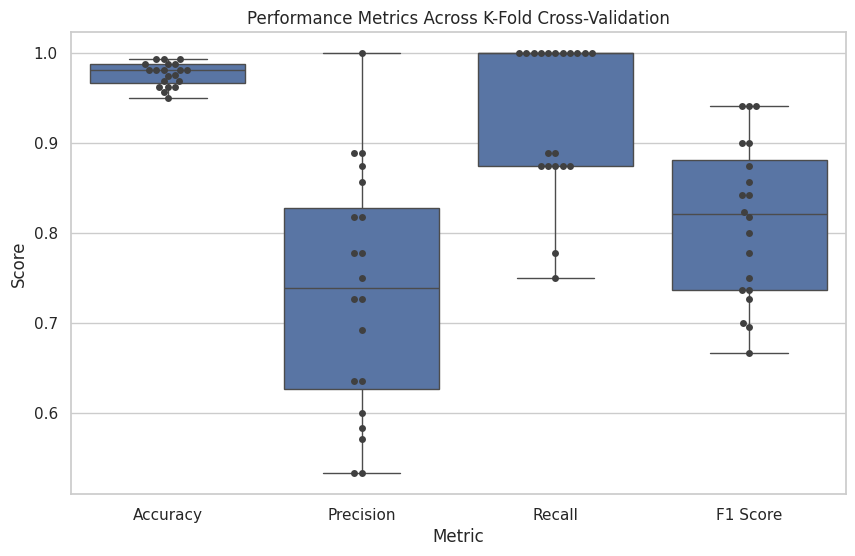

In [ ]:
def plot_classifier_metrics(accuracy_list=None,precision_list=None,recall_list=None,f1_list=None):
  # Data preparation
  metrics_data = {
      'Accuracy': accuracy_list,
      'Precision': precision_list,
      'Recall': recall_list,
      'F1 Score': f1_list
  }

  # Convert to long format for seaborn
  metrics_df = pd.DataFrame(metrics_data)
  metrics_df_long = pd.melt(metrics_df, var_name='Metric', value_name='Score')

  # Plotting
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='Metric', y='Score', data=metrics_df_long) # box plots for mean, quartiles, deviation
  sns.swarmplot(x='Metric', y='Score', data=metrics_df_long, color=".25") # view of each individual score

  plt.title('Performance Metrics Across K-Fold Cross-Validation')
  plt.ylabel('Score')
  plt.xlabel('Metric')
  plt.show()

plot_classifier_metrics(accuracy_list=accuracy_list,precision_list=precision_list,recall_list=recall_list,f1_list=f1_list)

In [ ]:
# Train a final classifier on all the train data and visualize its predictions on the test data
# SVM Classifier
final_clf = SVC(probability=True,kernel='rbf')

# Training the classifier
final_clf.fit(X_train, y_train)

# Predicting the labels on test set
y_pred = final_clf.predict(X_test)

# Calculating metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

# Average of each metric
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.92
Recall: 0.22
F1 Score: 0.35


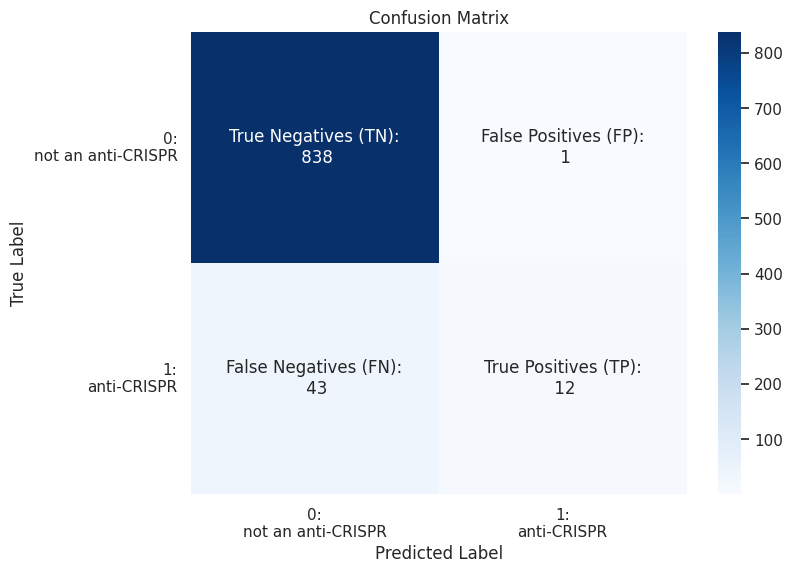

In [ ]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
cm_annotated = [
    [f'True Negatives (TN):\n {TN}',
      f'False Positives (FP):\n {FP}'
      ],
    [f'False Negatives (FN):\n {FN}',
      f'True Positives (TP):\n {TP}'
      ],
]

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=cm_annotated, fmt="", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks([.5,1.5],["0:\nnot an anti-CRISPR","1:\nanti-CRISPR"])
plt.yticks([.5,1.5],["0:\nnot an anti-CRISPR","1:\nanti-CRISPR"],rotation=0)
plt.ylabel("True Label")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


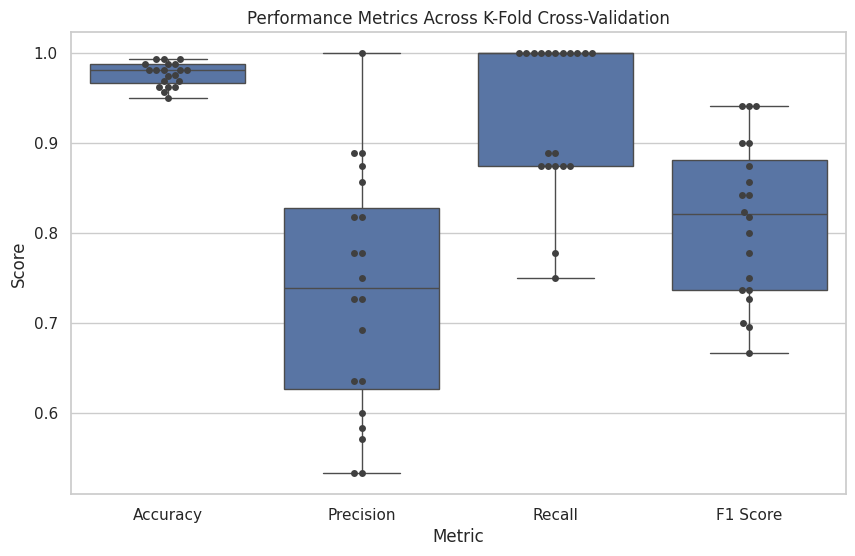

In [ ]:
def plot_classifier_metrics(accuracy_list=None,precision_list=None,recall_list=None,f1_list=None):
  # Data preparation
  metrics_data = {
      'Accuracy': accuracy_list,
      'Precision': precision_list,
      'Recall': recall_list,
      'F1 Score': f1_list
  }

  # Convert to long format for seaborn
  metrics_df = pd.DataFrame(metrics_data)
  metrics_df_long = pd.melt(metrics_df, var_name='Metric', value_name='Score')

  # Plotting
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='Metric', y='Score', data=metrics_df_long) # box plots for mean, quartiles, deviation
  sns.swarmplot(x='Metric', y='Score', data=metrics_df_long, color=".25") # view of each individual score

  plt.title('Performance Metrics Across K-Fold Cross-Validation')
  plt.ylabel('Score')
  plt.xlabel('Metric')
  plt.show()

plot_classifier_metrics(accuracy_list=accuracy_list,precision_list=precision_list,recall_list=recall_list,f1_list=f1_list)

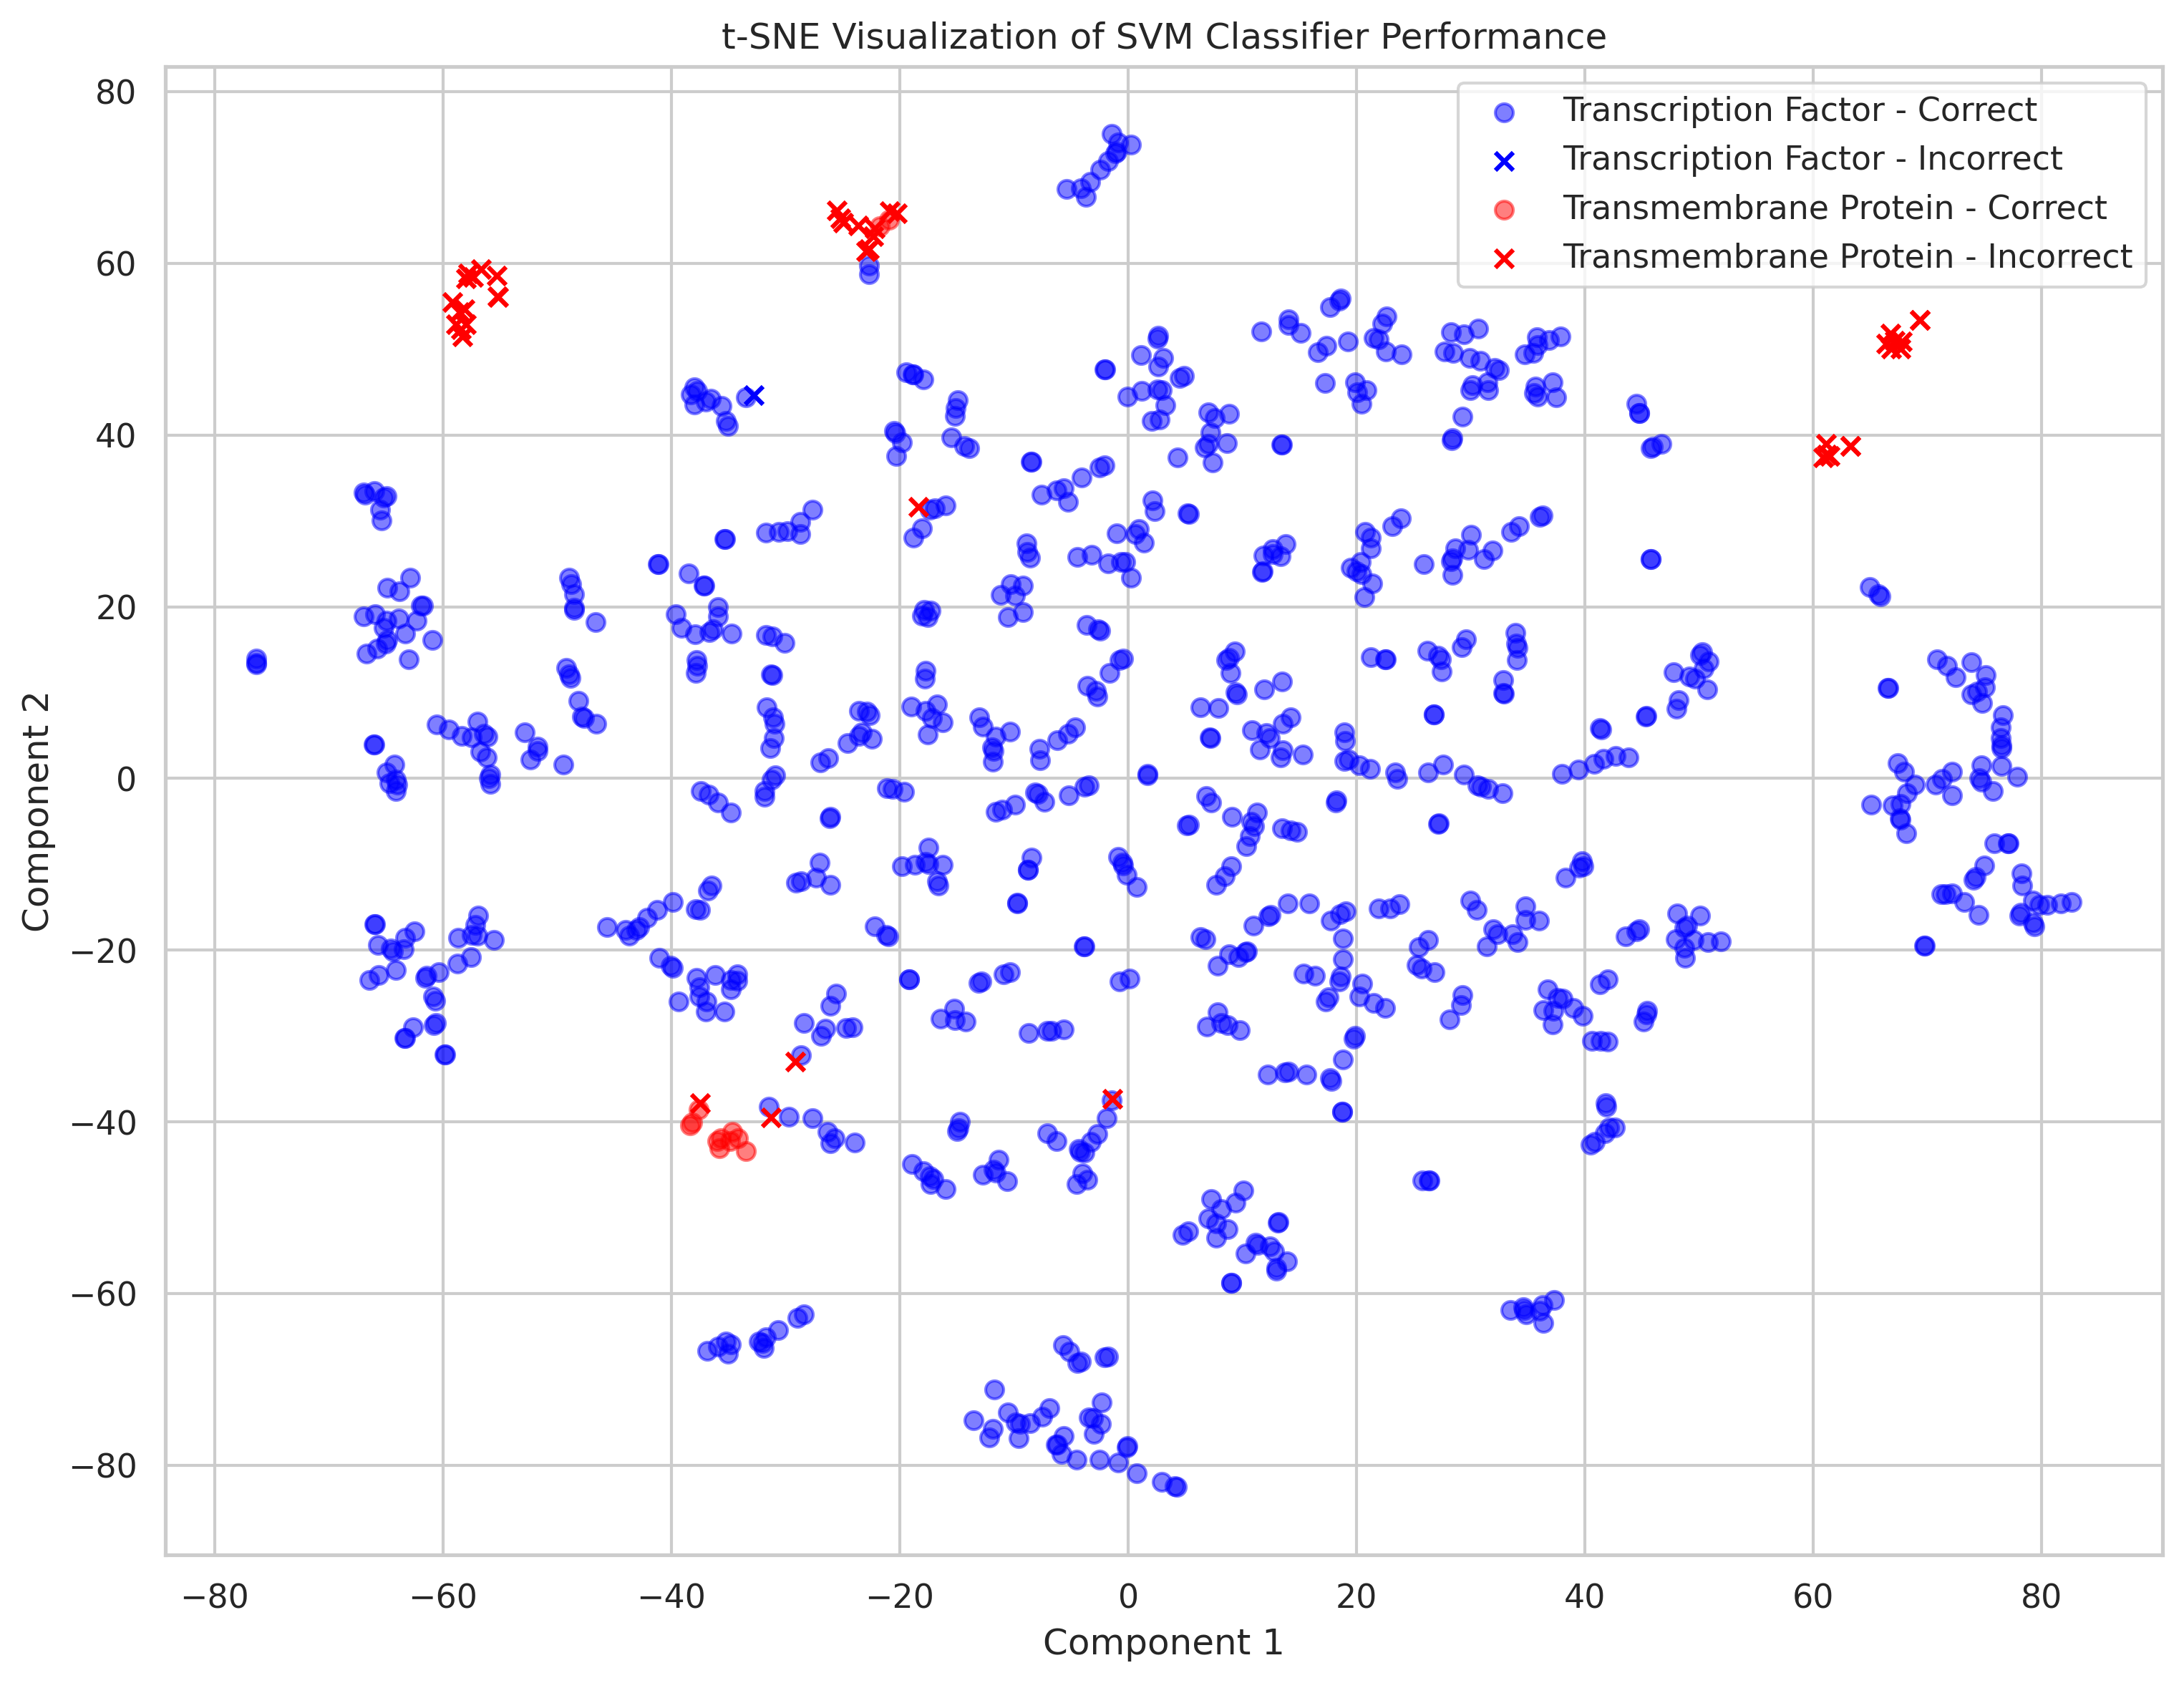

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=44)
X_tsne = tsne.fit_transform(X_test)

def accuracy_plot(y_test, y_pred):
  plt.figure(figsize=(12, 9), dpi=300)

  # Define class labels
  class_labels = ["Transcription Factor", "Transmembrane Protein"]

  # Colors and markers
  colors = ["blue", "red"]
  markers = ["o", "o"]

  # Iterate over each class
  for label, class_label in enumerate(class_labels):
      # Correctly classified points
      correctly_classified = (y_test == y_pred) & (y_test == label)
      plt.scatter(X_tsne[correctly_classified, 0], X_tsne[correctly_classified, 1],
                  color=colors[label], marker=markers[label], alpha=0.5,
                  label=f"{class_label} - Correct")

      # Incorrectly classified points
      incorrectly_classified = (y_test != y_pred) & (y_test == label)
      plt.scatter(X_tsne[incorrectly_classified, 0], X_tsne[incorrectly_classified, 1],
                  color=colors[label], marker='x', alpha=1,
                  label=f"{class_label} - Incorrect")

  plt.title("t-SNE Visualization of SVM Classifier Performance")
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.legend()
  plt.show()

accuracy_plot(y_test, y_pred)

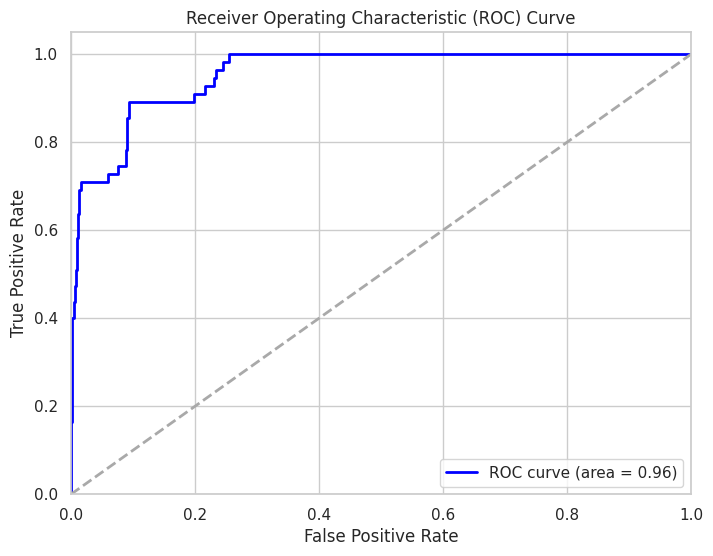

In [ ]:
# Get predicted probabilities
y_pred_prob = final_clf.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate and True Positive Rate for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MODEL EVALUATION - ESM

In [ ]:
#SVM w/ K-FOLD CROSS - ESM
# Prepare data
X_train = np.array(train_esm_embeddings.drop(columns=['Label']).reset_index(drop=True))
X_test = np.array(test_esm_embeddings.drop(columns=['Label']).reset_index(drop=True))

# Number of folds
n_splits = 10

# Create StratifiedKFold object
# fix random state for reproducible results
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# SVM Classifier
clf = SVC(kernel='rbf', class_weight='balanced')

# Lists to store results of each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Training the classifier
    clf.fit(X_train_fold, y_train_fold)

    # Predicting the labels on test set
    y_pred = clf.predict(X_val)

    # Calculating metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    f1 = metrics.f1_score(y_val, y_pred)

    # Append to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Average of each metric
print(f"Average Accuracy: {np.mean(accuracy_list):.2f}")
print(f"Average Precision: {np.mean(precision_list):.2f}")
print(f"Average Recall: {np.mean(recall_list):.2f}")
print(f"Average F1 Score: {np.mean(f1_list):.2f}")

Average Accuracy: 0.97
Average Precision: 0.65
Average Recall: 0.93
Average F1 Score: 0.76


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


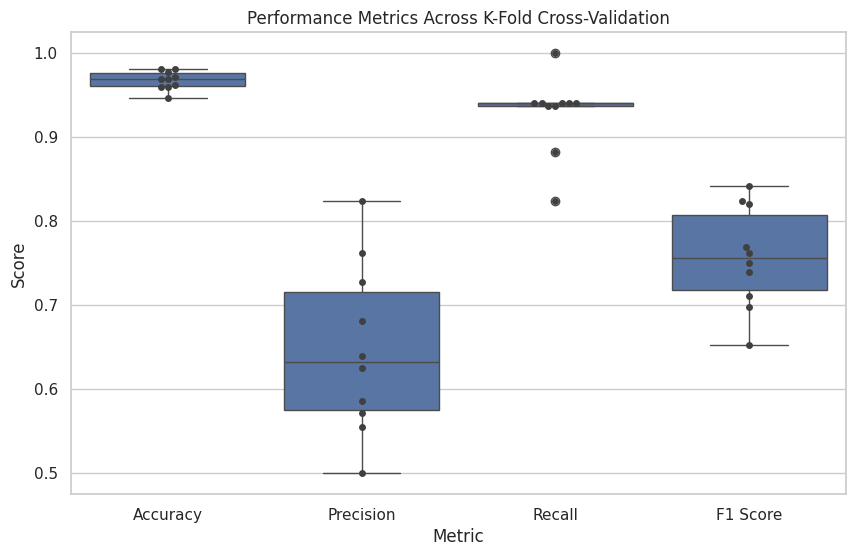

In [ ]:
def plot_classifier_metrics(accuracy_list=None,precision_list=None,recall_list=None,f1_list=None):
  # Data preparation
  metrics_data = {
      'Accuracy': accuracy_list,
      'Precision': precision_list,
      'Recall': recall_list,
      'F1 Score': f1_list
  }

  # Convert to long format for seaborn
  metrics_df = pd.DataFrame(metrics_data)
  metrics_df_long = pd.melt(metrics_df, var_name='Metric', value_name='Score')

  # Plotting
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='Metric', y='Score', data=metrics_df_long) # box plots for mean, quartiles, deviation
  sns.swarmplot(x='Metric', y='Score', data=metrics_df_long, color=".25") # view of each individual score

  plt.title('Performance Metrics Across K-Fold Cross-Validation')
  plt.ylabel('Score')
  plt.xlabel('Metric')
  plt.show()

plot_classifier_metrics(accuracy_list=accuracy_list,precision_list=precision_list,recall_list=recall_list,f1_list=f1_list)

In [ ]:
# Train a final classifier on all the train data and visualize its predictions on the test data
# SVM Classifier
final_clf = SVC(probability=True,kernel='rbf')

# Training the classifier
final_clf.fit(X_train, y_train)

# Predicting the labels on test set
y_pred = final_clf.predict(X_test)

# Calculating metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

# Average of each metric
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.86
Recall: 0.22
F1 Score: 0.35


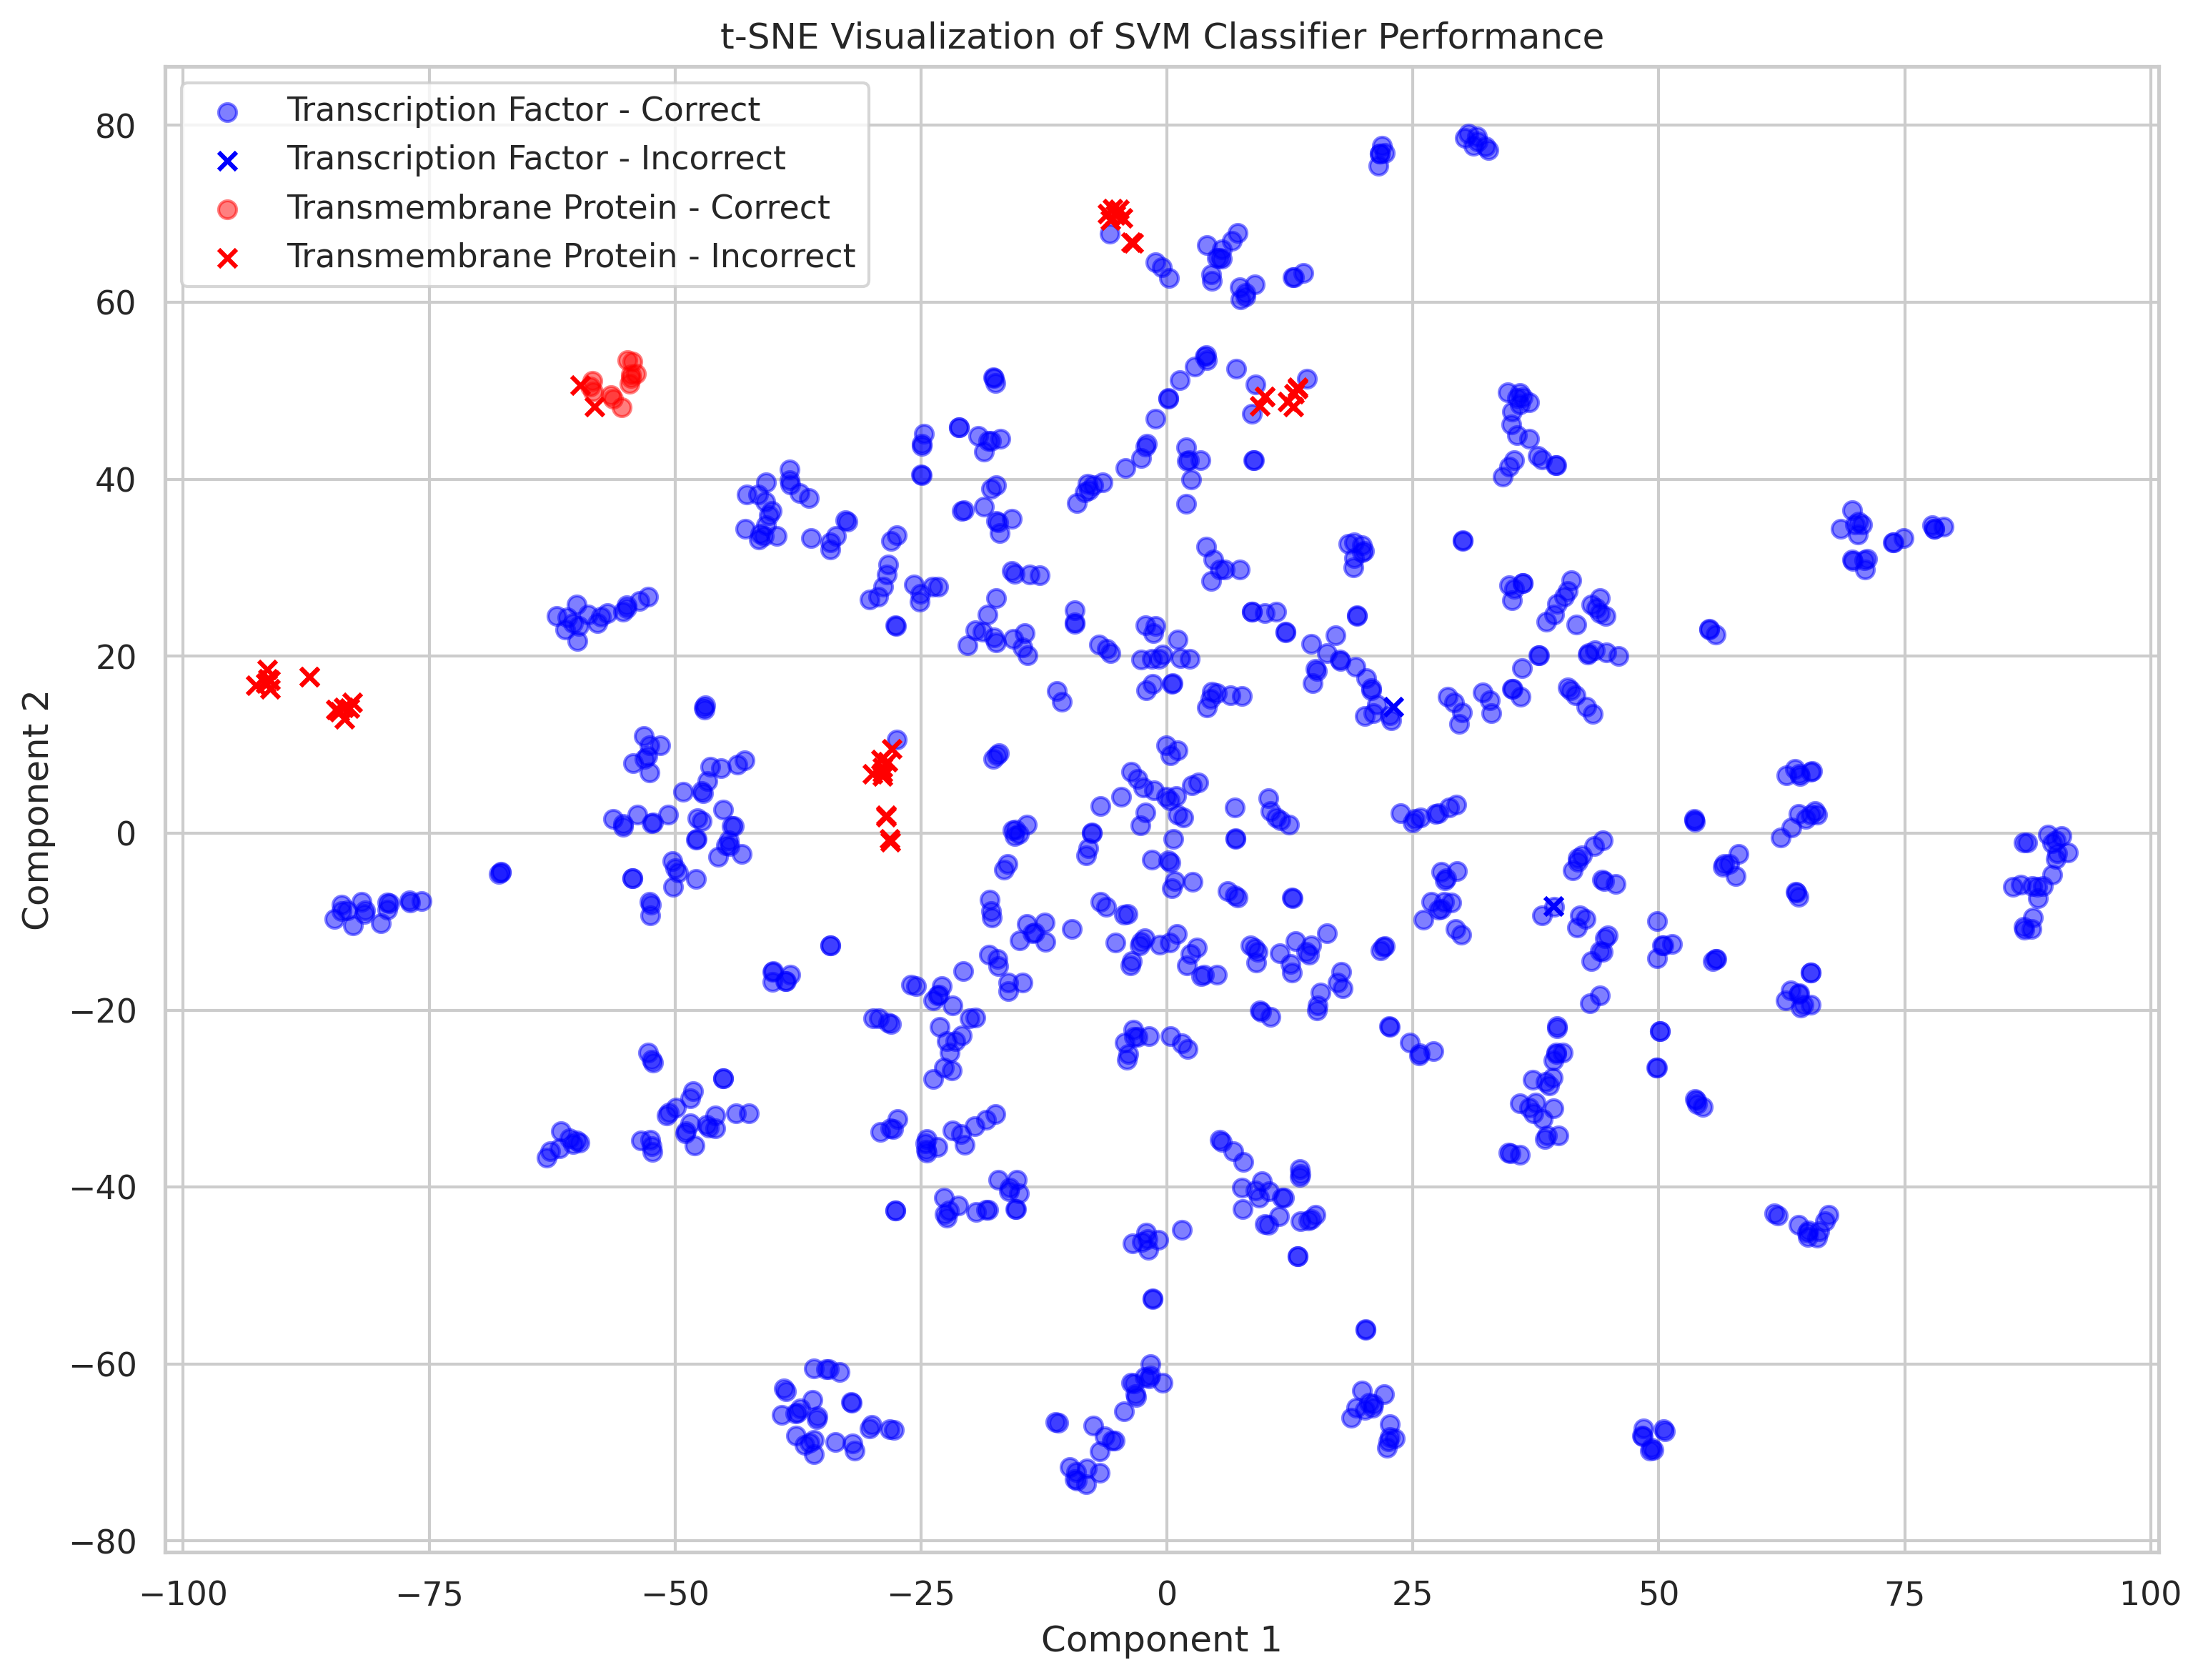

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=44)
X_tsne = tsne.fit_transform(X_test)

def accuracy_plot(y_test, y_pred):
  plt.figure(figsize=(12, 9), dpi=300)

  # Define class labels
  class_labels = ["Transcription Factor", "Transmembrane Protein"]

  # Colors and markers
  colors = ["blue", "red"]
  markers = ["o", "o"]

  # Iterate over each class
  for label, class_label in enumerate(class_labels):
      # Correctly classified points
      correctly_classified = (y_test == y_pred) & (y_test == label)
      plt.scatter(X_tsne[correctly_classified, 0], X_tsne[correctly_classified, 1],
                  color=colors[label], marker=markers[label], alpha=0.5,
                  label=f"{class_label} - Correct")

      # Incorrectly classified points
      incorrectly_classified = (y_test != y_pred) & (y_test == label)
      plt.scatter(X_tsne[incorrectly_classified, 0], X_tsne[incorrectly_classified, 1],
                  color=colors[label], marker='x', alpha=1,
                  label=f"{class_label} - Incorrect")

  plt.title("t-SNE Visualization of SVM Classifier Performance")
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.legend()
  plt.show()

accuracy_plot(y_test, y_pred)

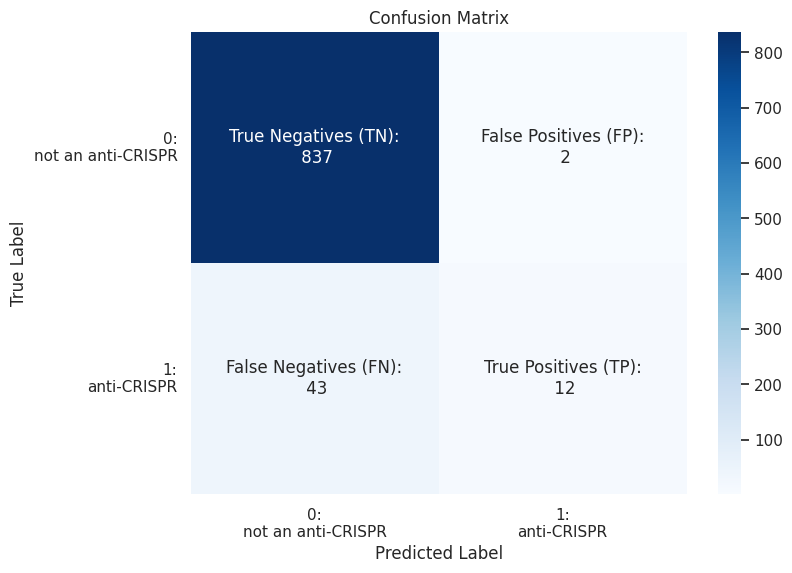

In [ ]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
cm_annotated = [
    [f'True Negatives (TN):\n {TN}',
      f'False Positives (FP):\n {FP}'
      ],
    [f'False Negatives (FN):\n {FN}',
      f'True Positives (TP):\n {TP}'
      ],
]

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=cm_annotated, fmt="", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks([.5,1.5],["0:\nnot an anti-CRISPR","1:\nanti-CRISPR"])
plt.yticks([.5,1.5],["0:\nnot an anti-CRISPR","1:\nanti-CRISPR"],rotation=0)
plt.ylabel("True Label")
plt.show()

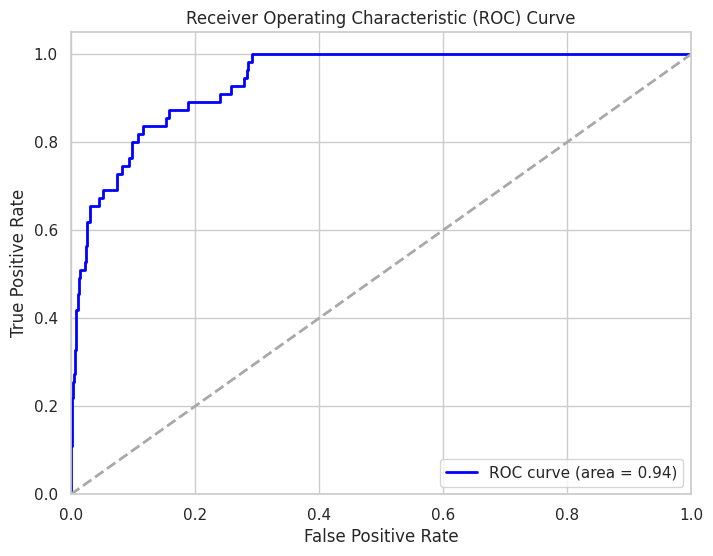

In [ ]:
# Get predicted probabilities
y_pred_prob = final_clf.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate and True Positive Rate for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

My two metrics of choice are accuracy and auroc. Classification accuracy is defined as the ratio of the number of correct predictions to the total number of input samples. For this metric, we see that onehot embeddings and ESM performed the best, with accuracies of 0.95, while VHSE had an accuracy of 0.9172.

For AUROC, ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. For this, we once again observe that the onehot model and ESM model had the highest AUROC values, with 0.94, and 0.93, respectively. These are high values, and offer some degree of confidence about the performance of the models. VHSE performed markedly worse, with an auroc of 0.83, which is still not bad by any means.

# Saving model so I can use it later

In [ ]:
!pip install joblib

In [ ]:
from joblib import dump

# Save the model to a file
dump(clf, 'svm_classifier_model.joblib')


['svm_classifier_model.joblib']

# Loading the model and using it

In [ ]:
from joblib import load

# Load the model from the file
clf_loaded = load('/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A/AntiCRISPRClassificationModel.joblib')



In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

def classify_protein_sequence(model, embedding):

    prediction = model.predict([embedding])
    if prediction == 1:
        return "Anti-CRISPR"
    else:
        return "Not Anti-CRISPR"


In [ ]:
# Assuming you have a function to generate embeddings for new sequences
# new_sequence_embedding = get_embedding(your_new_sequence_here)

# Use the loaded model to make predictions
classification_result = classify_protein_sequence(clf_loaded, X_test[0])
print(classification_result)


Not Anti-CRISPR


# Seeing what my classification model thinks about my 10,000 generated sequences. First I need to embed my sequences.

In [ ]:
import pandas as pd

# Base path
base_path = '/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A/generated_sequences/'

file_paths = [f'{base_path}df_{i}.csv' for i in range(1, 11)]

#load and combine
combined_df = pd.concat([pd.read_csv(path) for path in file_paths], ignore_index=True)
combined_df.info(), combined_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sequence    10000 non-null  object 
 1   Perplexity  10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


(None,
                                             Sequence  Perplexity
 0  |endoftext|>\nMTLSEKIITTAQKRYYDAMNEFEAIISKELEQ...   17.050312
 1  |endoftext|>\nMADDHMTITTAQKRYYDAMNEFEAIISKELEQ...   17.843086
 2  |endoftext|>\nMPEPMPRFIWGFAIFTPKGGEVMHDEFEYLTH...   20.535832
 3  |endoftext|>\nMNINELIREIKNKDYTAKLSGTDSNSITQLII...   21.373807
 4  |endoftext|>\nMNINELIREIKNKDYTAKLSGTDSNSITQLII...   21.373807)

In [ ]:

sorted_df = combined_df.sort_values(by="Perplexity", ascending=True)
print(sorted_df.head())


                                               Sequence  Perplexity
9000  |endoftext|>\nMTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNT...   13.802050
6000  |endoftext|>\nMTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNT...   13.802050
7000  |endoftext|>\nMSEIDNTEIDNTEIDNTEIDNTEIDNTEIDNT...   13.958719
9001  |endoftext|>\nMKEKFSLYDFLAIILPGIAFIVVFRIIFSSLH...   14.240605
7001  |endoftext|>\nMKEKFSLYDFLAIILPGIAFIVVFRIIFSSLH...   14.240605


In [ ]:
sorted_df["Sequence"][0]

'|endoftext|>\nMTLSEKIITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYIDETLVQSTCLDVEGETYYINFVVTNEDDFKLATDKDKEKHDKQEVIIKSELN\nMSIKLLDEFLKKHSKTRYQLSKLTGISQNTLNDYNKKELNKYSVSFMRALSMCAGISTFDVFIELAELEKSYDDLAGFKHLLDKYKLSFPAQEFELYCLIKEFESANIEVLPFTFNRFENETHVDIEKDVRKALENAITVLKEKKNELI\nMNINELIREIK'

In [ ]:
# Remove '|endoftext|>' and '\n' from the "Sequence" column
sorted_df["Sequence"] = sorted_df["Sequence"].str.replace("|endoftext|>\n", "", regex=False).replace("\n", "", regex=True)
sorted_df["Sequence"] = sorted_df["Sequence"].str.replace("|endoftext|>\n", "", regex=False).replace("\n", "", regex=True)


print(sorted_df.head())


                                               Sequence  Perplexity
9000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.802050
6000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.802050
7000  MSEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.958719
9001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   14.240605
7001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   14.240605


In [ ]:
sorted_df["Sequence"][0]

'MTLSEKIITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYIDETLVQSTCLDVEGETYYINFVVTNEDDFKLATDKDKEKHDKQEVIIKSELNMSIKLLDEFLKKHSKTRYQLSKLTGISQNTLNDYNKKELNKYSVSFMRALSMCAGISTFDVFIELAELEKSYDDLAGFKHLLDKYKLSFPAQEFELYCLIKEFESANIEVLPFTFNRFENETHVDIEKDVRKALENAITVLKEKKNELIMNINELIREIK'

In [ ]:
import pandas as pd

# Assuming sorted_df is your DataFrame

# Define the set of 20 amino acid letters
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")

# Function to find invalid characters in a sequence
def find_invalid_characters(sequence):
    return set(sequence) - amino_acids

# Check each sequence for characters not in the amino acid set and find invalid characters
invalid_characters_info = sorted_df["Sequence"].apply(lambda x: find_invalid_characters(x))

# Filter sequences that have invalid characters
invalid_sequences = sorted_df[invalid_characters_info.apply(bool)]

# Count of sequences with invalid characters
invalid_sequences_count = invalid_sequences.shape[0]

# Add a column to the invalid sequences DataFrame to show invalid characters
invalid_sequences["Invalid Characters"] = invalid_characters_info[invalid_characters_info.apply(bool)]

print(f"Count of sequences with invalid characters: {invalid_sequences_count}")
print("Invalid characters found in each sequence:")
print(invalid_sequences[["Sequence", "Invalid Characters"]].head())


Count of sequences with invalid characters: 402
Invalid characters found in each sequence:
                                               Sequence Invalid Characters
1001  MNEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRAPRFT...                {X}
1003  MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRAPRFT...                {X}
1007  MNINELIREIKNKDYTAKLSGTDSNSITQLIIHVNNDGNEYGISES...                {X}
1005  MNINELIREIKNKDYTAKLSGTDSNSITQLIIHVNNDGNEYGISES...                {X}
1004  MNINELIREIKNKDYTAKLSGTDSNSITQLIIHVNNDGNEYGISES...                {X}


<ipython-input-75-ccb04428a7d6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_sequences["Invalid Characters"] = invalid_characters_info[invalid_characters_info.apply(bool)]


now i embed

In [ ]:
# Assuming sorted_df is your DataFrame

# Filter out sequences that contain the character "|"
cleaned_df = sorted_df[~sorted_df["Sequence"].str.contains("\|", regex=True)]

print(f"Original DataFrame size: {sorted_df.shape[0]}")
print(f"Cleaned DataFrame size (without '|' characters): {cleaned_df.shape[0]}")


Original DataFrame size: 10000
Cleaned DataFrame size (without '|' characters): 9999


In [ ]:
cleaned_df.head()

Sequence  Perplexity
9000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.802050
6000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.802050
7000  MSEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.958719
9001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   14.240605
7001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   14.240605

In [ ]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Create a DataFrame with the natural sequence data - we'll just use ONE sequence for now
sequence_data = pd.DataFrame(cleaned_df['Sequence'])

# Initialize an empty list to store the averaged ESM embeddings
avg_embeddings = []

# Iterate through the DataFrame rows
for index, row in sequence_data.iterrows():
    sequence = row["Sequence"]

    # Prepare data for the ESM model
    batch_labels, batch_strs, batch_tokens = batch_converter([("", sequence)])
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (can be done on CPU!)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging
    avg_embedding = token_representations[0, 1 : batch_lens[0] - 1].mean(0)
    avg_embeddings.append(avg_embedding.numpy())

# Create a new DataFrame with the averaged embeddings
gen_embeddings = pd.DataFrame(avg_embeddings)
# Display the DataFrame
gen_embeddings

0         1         2         3         4         5         6    \
0    -0.242688 -0.870009  0.047641  0.161272  0.191643 -0.051263 -0.014092   
1    -0.242688 -0.870009  0.047641  0.161272  0.191643 -0.051263 -0.014092   
2    -0.248499 -0.872391  0.050681  0.156830  0.191350 -0.051038 -0.009418   
3    -0.052528 -0.048065  0.074497  0.232713  0.119341 -0.060904  0.154796   
4    -0.052528 -0.048065  0.074497  0.232713  0.119341 -0.060904  0.154796   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.037603  0.158736  0.276687 -0.070517  0.354648 -0.035251  0.092913   
9995  0.211823  0.155571  0.024469 -0.114671  0.500950  0.063997  0.086987   
9996 -0.113669 -0.112650  0.118185 -0.047253  0.057430 -0.162026  0.093141   
9997 -0.256892  0.143166  0.316283  0.043492  0.198457 -0.308743  0.170412   
9998  0.097412  0.336723  0.133132 -0.324162  0.466018  0.190903  0.158846   

           7         8         9    ...       310       311       312  \
0     0.328875  0.234121 -0.013091  ...  0.088909 -0.072510 -0.360952   
1     0.328875  0.234121 -0.013091  ...  0.088909 -0.072510 -0.360952   
2     0.332407  0.225977 -0.007332  ...  0.090557 -0.075612 -0.360200   
3     0.005533 -0.022853 -0.111922  ... -0.074939  0.048441  0.030582   
4     0.005533 -0.022853 -0.111922  ... -0.074939  0.048441  0.030582   
...        ...       ...       ...  ...       ...       ...       ...   
9994  0.138624  0.021848 -0.076753  ... -0.160178  0.205605 -0.077409   
9995  0.118020 -0.028760 -0.245272  ... -0.060833  0.135314 -0.030889   
9996 -0.066944 -0.267451 -0.176133  ... -0.107984 -0.078225  0.037638   
9997  0.194330 -0.073953 -0.061276  ... -0.083577  0.297670 -0.133474   
9998  0.001616 -0.051862 -0.186844  ...  0.036812  0.158219 -0.156905   

           313       314       315       316       317       318       319  
0     0.459381  0.105642  0.311379 -0.243863 -0.076856 -0.187915 -0.248128  
1     0.459381  0.105642  0.311379 -0.243863 -0.076856 -0.187915 -0.248128  
2     0.459171  0.106292  0.315321 -0.241274 -0.074256 -0.188643 -0.246831  
3    -0.005389  0.039644 -0.036352 -0.167722 -0.050376 -0.039189  0.159350  
4    -0.005389  0.039644 -0.036352 -0.167722 -0.050376 -0.039189  0.159350  
...        ...       ...       ...       ...       ...       ...       ...  
9994  0.028744 -0.073425 -0.422420 -0.172840  0.394669 -0.315003 -0.003714  
9995 -0.065817 -0.009667 -0.293350 -0.096178  0.185816 -0.054439 -0.178826  
9996  0.076456 -0.010502 -0.082689 -0.066471  0.191150  0.003717 -0.101681  
9997 -0.045652 -0.111982 -0.487872 -0.209439  0.203503 -0.429035  0.243875  
9998  0.171680 -0.133527 -0.440866 -0.033104  0.300220 -0.124002 -0.197671  

[9999 rows x 320 columns]

In [ ]:
filename = 'gen_embeddings.pkl'
gen_embeddings.to_pickle(filename)

print(f'DataFrame saved to {filename}')


DataFrame saved to gen_embeddings.pkl


# now i want to run everything through my classifier and only keep those that are classified as being real anti-crisprs.

In [ ]:
import pandas as pd

# Assuming gen_embeddings is your DataFrame and clf is your trained model

# Function to classify each embedding
def classify_embedding(row):
    # Reshape row to 2D array as expected by the model
    embedding_2d = row.values.reshape(1, -1)
    # Predict and return the classification result
    return clf.predict(embedding_2d)[0]

# Apply the classification function to each row
gen_embeddings['Classification'] = gen_embeddings.apply(classify_embedding, axis=1)

# Filter the DataFrame to keep only rows classified as positive for anti-CRISPRs
# Assuming 1 indicates a positive classification for anti-CRISPRs
positive_anti_crisprs = gen_embeddings[gen_embeddings['Classification'] == 1]

# Drop the 'Classification' column if no longer needed, retaining only the original embeddings
positive_anti_crisprs = positive_anti_crisprs.drop(columns=['Classification'])




In [ ]:
positive_anti_crisprs

0         1         2         3         4         5         6    \
7    -0.098366 -0.108939  0.030028  0.118879  0.230926  0.047906  0.100295   
8    -0.063010 -0.103285  0.082246  0.153767  0.167978  0.041942  0.108227   
9    -0.068492 -0.116929  0.061570  0.130377  0.176414  0.059500  0.095583   
10   -0.063402 -0.101053  0.080604  0.157140  0.170069  0.046079  0.109961   
11   -0.063402 -0.101053  0.080604  0.157140  0.170069  0.046079  0.109961   
...        ...       ...       ...       ...       ...       ...       ...   
9936 -0.062499 -0.043227  0.105468  0.111981  0.183485  0.070993  0.060196   
9942 -0.084789 -0.034873  0.208755  0.064434  0.159389  0.152928 -0.004660   
9962 -0.006974 -0.062256  0.051046  0.064783  0.220633  0.157410  0.144074   
9968  0.074506  0.172587  0.166657 -0.008890  0.312098  0.189850  0.083434   
9977  0.191267  0.217814  0.049417 -0.135682  0.376920  0.270835  0.221685   

           7         8         9    ...       310       311       312  \
7    -0.047528 -0.093201 -0.168687  ...  0.114492  0.060155  0.053156   
8    -0.027239 -0.030148 -0.176273  ...  0.108125  0.028919  0.054727   
9    -0.017343 -0.007081 -0.167815  ...  0.080698  0.051860  0.066539   
10   -0.029196 -0.022287 -0.182368  ...  0.100072  0.033608  0.048667   
11   -0.029196 -0.022287 -0.182368  ...  0.100072  0.033608  0.048667   
...        ...       ...       ...  ...       ...       ...       ...   
9936 -0.065146 -0.027402 -0.159787  ...  0.088428  0.082688  0.031489   
9942 -0.019871 -0.047137 -0.190739  ...  0.091937  0.047223  0.013842   
9962  0.023865 -0.059892 -0.123821  ... -0.047454  0.049155 -0.065367   
9968 -0.032983 -0.110369 -0.199109  ...  0.031671  0.043727 -0.083122   
9977  0.036679 -0.176101 -0.179013  ... -0.031106  0.077443 -0.229406   

           313       314       315       316       317       318       319  
7     0.069468  0.021083 -0.130271 -0.172047  0.079720  0.050546  0.049318  
8     0.053642 -0.009594 -0.134074 -0.235970  0.048888 -0.008915  0.105048  
9     0.057207  0.012909 -0.132763 -0.220590  0.093321 -0.031851  0.085524  
10    0.055159 -0.011879 -0.140291 -0.237320  0.049748 -0.013395  0.106877  
11    0.055159 -0.011879 -0.140291 -0.237320  0.049748 -0.013395  0.106877  
...        ...       ...       ...       ...       ...       ...       ...  
9936  0.057196  0.080646 -0.126379 -0.168496  0.025241  0.052263  0.061391  
9942 -0.007755  0.034614 -0.084749 -0.139956  0.089498  0.000498 -0.009901  
9962  0.064428 -0.014200 -0.195732 -0.129879  0.160771 -0.011937 -0.034161  
9968  0.141475  0.031725 -0.239615 -0.089128  0.093283  0.033678 -0.097062  
9977  0.155898 -0.057703 -0.309531 -0.090412  0.067974 -0.000748 -0.244287  

[7247 rows x 320 columns]

now i want to get the perplexities of these proteins

In [ ]:
# Assuming positive_anti_crisprs and cleaned_df are your DataFrames

# Use the indices from positive_anti_crisprs to select rows from cleaned_df
selected_proteins = cleaned_df.loc[positive_anti_crisprs.index]
sorted_selected_proteins = selected_proteins.sort_values(by="Perplexity", ascending=True)
print(sorted_selected_proteins[['Sequence', 'Perplexity']])



                                               Sequence     Perplexity
6000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...      13.802050
9001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...      14.240605
3000  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...      14.240605
7001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...      14.240605
6001  MLHPCVCLDACACVRACVRACVRACVRACVRACVRACVRACVRACV...      15.531646
...                                                 ...            ...
2999  MKKSLIALAVLAGLSGVAFAQSSVTLYGIVDAGVAYSNNVGGKSSF...   91481.585062
4998  MKKILLATTVLAASTAAQAEITFNGLELGVSASQFEGETDAAGNDL...  135024.489010
3999  MKKILLSALFVFLAQVFNAQTIYINEIHYDNSGTDTGNDGFEFIEL...  142567.639716
4999  MRIIHVNKFYPPNIGGIESVVRELAEAFVREGHEVEVVSSVRSTTE...  214394.849309
5999  MKKILLIAFFAVSLIGVNAQTEKGTIRADFAFGVKGGVNFSNFTAE...  262729.662236

[7247 rows x 2 columns]


#picking the best 10 by perplexity to alphafold them.

In [ ]:
# Remove duplicate sequences while keeping the entry with the lowest perplexity for each sequence
unique_sorted_selected_proteins = sorted_selected_proteins.drop_duplicates(subset=['Sequence'], keep='first')
chosen_proteins = unique_sorted_selected_proteins.head(10)

# Display the chosen_proteins DataFrame to verify it contains unique sequences
print(chosen_proteins)


                                               Sequence  Perplexity
6000  MTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDNTEIDN...   13.802050
9001  MKEKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   14.240605
6001  MLHPCVCLDACACVRACVRACVRACVRACVRACVRACVRACVRACV...   15.531646
2000  MTLPMPRFIWGFAIFTPKGGEVMHDEFEYLTHTRSPRFTCRVVELE...   16.101298
6002  MSLSEKIITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDY...   16.570762
6003  MTDPIADMLTRVRAAEQTPEFSQDLLNDSDYLVITKNEAYAVALCM...   16.613933
6004  MRDKFSLYDFLAIILPGIAFIVVFRIIFSSLHLSLPVDIPLGLEST...   17.493152
3001  MSYLISNGQIIAKTSATLASGQSVAFTAVSYTHLRIEAKPIDGELG...   18.648848
7002  MTLSEKIITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDY...   19.131531
5000  MSRFTCRVVELEDMPAEPEEDGDIDGRIVHFDNPKRMFYITDLGLA...   20.609479


we'll now pickle these and move them to the next stage, which is to run them through af2


In [ ]:

filename = 'chosen_proteins.pkl'
chosen_proteins.to_pickle(filename)

print(f'DataFrame saved to {filename}')


DataFrame saved to chosen_proteins.pkl


[click this link to go to the next step of my project: folding my top 10 sequences using AF2 and ESMFold](https://colab.research.google.com/drive/1LzCktl7NJe8p4hJBS1Uq8U80lfATY2T1#scrollTo=kj7IGgRycaXo)